# EDA

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import datetime
import plotly.figure_factory as ff
from google.colab import files
from scipy.stats import norm
import plotly.express as px
from fbprophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score


In [3]:
#pip install pystan prophet

In [4]:
#pip install pyod

In [2]:
pip install pmdarima

# Loading the data from GDrive

In [3]:
pwd

'/content'

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
%cd /content/gdrive/MyDrive/Colab Notebooks/Walmart

/content/gdrive/MyDrive/Colab Notebooks/Walmart


In [8]:
pwd

'/content/gdrive/MyDrive/Colab Notebooks/Walmart'

In [9]:
!ls

avgsalesperdept.png	   network.gv		 weekly1.csv
avgsalesperstore.png	   network.gv.pdf	 weekly2.csv
avg_sales_store.png	   sampleSubmission.csv  weekly.csv
effect_of_temp.png	   Scenario1.csv	 weekly_merge.csv
features.csv		   stores.csv		 weekly_merge.xlsx
fetureImpLightGBM.pdf	   test.csv		 XGAct.pdf
holidayDist.png		   times.csv		 XGPred.pdf
myImagePDF.pdf		   train.csv
negative_weekly_sales.png  week.csv


In [10]:
raw_features=pd.read_csv("features.csv")
raw_stores=pd.read_csv("stores.csv")
raw_data=pd.read_csv("train.csv")

# Understanding the Data and getting an impression on what we are actually working with

In [11]:
print(raw_features.shape)
print(raw_stores.shape)
print(raw_data.shape)

(8190, 12)
(45, 3)
(421570, 5)


In [12]:
raw_stores.isna().sum()

Store    0
Type     0
Size     0
dtype: int64

In [13]:
raw_data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
dtype: int64

In [14]:
raw_features.isna().sum().sort_values(ascending=True)

Store              0
Date               0
Temperature        0
Fuel_Price         0
IsHoliday          0
CPI              585
Unemployment     585
MarkDown5       4140
MarkDown1       4158
MarkDown3       4577
MarkDown4       4726
MarkDown2       5269
dtype: int64

In [15]:
#so as we can see that the dataset containg stores data and training dataset are clean without NA.. 
#So lets proceed with the features dataset 
# Things that we know from the dataset provider about the features dataset and Initial Impressions
# 1) Duration of the dataset is from 2010-02-05 to 2012-11-01 (5th Feb 2010 - 1st November 2012 )
# 2) We have also been told by walmart that the markdown values have been only recorded after November 2011
# 3) Also have been informed that not all stores have markdowns at the same time 
# 4) The above two point explains the huge number of Null Values for Markdowns as 
#    the timeframe for which markdowns have not been recorded at all is almost half the duration of the dataset given to us.. on top of those we have 3rd point
# Lets come to markdown after dealing with other NA's
# 5) So essesntialy the missing data is from CPI and Unemployment
#
#

In [16]:
raw_features.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,8190.0,23.000000,12.987966,1.000,12.000000,23.000000,34.000000,45.000000
Temperature,8190.0,59.356198,18.678607,-7.290,45.902500,60.710000,73.880000,101.950000
Fuel_Price,8190.0,3.405992,0.431337,2.472,3.041000,3.513000,3.743000,4.468000
MarkDown1,4032.0,7032.371786,9262.747448,-2781.450,1577.532500,4743.580000,8923.310000,103184.980000
MarkDown2,2921.0,3384.176594,8793.583016,-265.760,68.880000,364.570000,2153.350000,104519.540000
MarkDown3,3613.0,1760.100180,11276.462208,-179.260,6.600000,36.260000,163.150000,149483.310000
MarkDown4,3464.0,3292.935886,6792.329861,0.220,304.687500,1176.425000,3310.007500,67474.850000
MarkDown5,4050.0,4132.216422,13086.690278,-185.170,1440.827500,2727.135000,4832.555000,771448.100000
CPI,7605.0,172.460809,39.738346,126.064,132.364839,182.764003,213.932412,228.976456
Unemployment,7605.0,7.826821,1.877259,3.684,6.634000,7.806000,8.567000,14.313000


In [17]:
#Immediately the things that can be observed from the above describe function are : 
# There are negative values for markdowns M1,M2,M3,M5 which usually should be positive and thus have to be tweaked and has to be check 
#  lets try to visualize the cpi distribution and Unemployment distribution

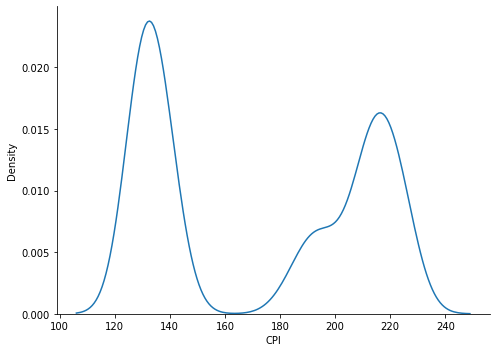

In [18]:
sns.displot(
    data=raw_features,
    x="CPI", 
    kind="kde",
    aspect=1.4,
   
    
)

In [19]:
# Imputing mean values for cpi can change the distribution of the dataset as CPI is not distributed normally 

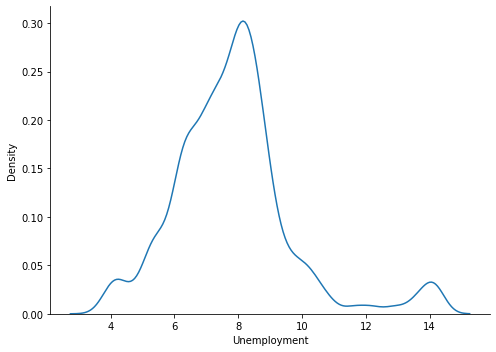

In [20]:
sns.displot(
    data=raw_features,
    x="Unemployment", 
    kind="kde",
    aspect=1.4,
    
)

In [21]:
print("Mean :",raw_features["CPI"].mean())
print("Median :",raw_features["CPI"].median())
print("Mode :",raw_features["CPI"].mode())

Mean : 172.46080918276078
Median : 182.7640032
Mode : 0    132.716097
dtype: float64


In [22]:
print("Mean :",raw_features["Unemployment"].mean())
print("Median :",raw_features["Unemployment"].median())
print("Mode :",raw_features["Unemployment"].mode())

Mean : 7.826821038790305
Median : 7.806
Mode : 0    8.099
dtype: float64


In [23]:
"""sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=raw_features["Unemployment"])"""

'sns.set_theme(style="whitegrid")\nax = sns.boxplot(x=raw_features["Unemployment"])'

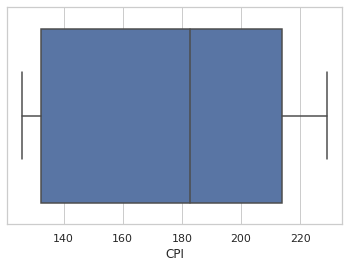

In [24]:
sns.set_theme(style="whitegrid")
ax = sns.boxplot(x=raw_features["CPI"])

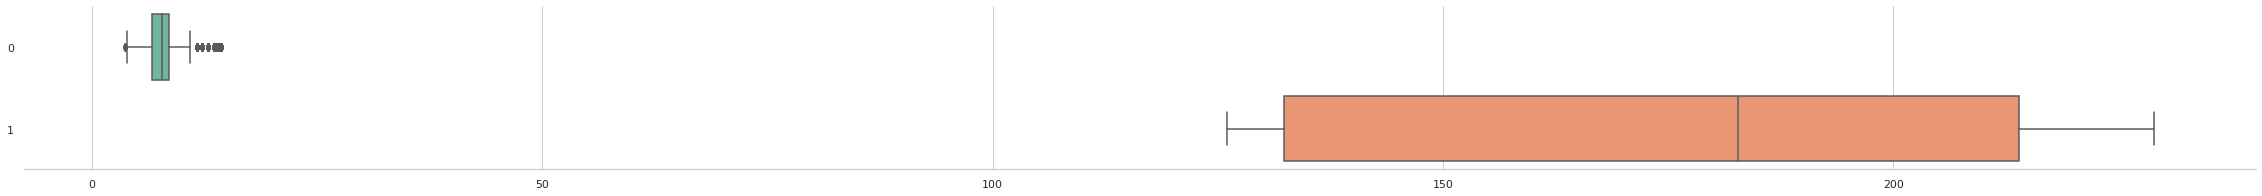

In [25]:
fig, ax = plt.subplots(figsize=(40, 3))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.grid(color='grey', axis='y', linestyle='-', linewidth=0.25, alpha=0.5)
ax = sns.boxplot(data=[raw_features["Unemployment"],raw_features["CPI"]], orient="h", palette="Set2")
plt.show()

In [26]:
raw_features[(raw_features['CPI'].isnull())&(raw_features['Unemployment'].isnull())]

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
169,1,2013-05-03,66.66,3.386,2298.63,2.00,129.90,55.46,1301.04,NaN,NaN,False
170,1,2013-05-10,63.90,3.392,4624.61,83.88,42.38,1618.31,8144.90,NaN,NaN,False
171,1,2013-05-17,69.53,3.454,16170.50,92.00,8.32,4127.24,6206.97,NaN,NaN,False
172,1,2013-05-24,77.19,3.494,7959.89,178.00,1621.47,3152.57,2938.70,NaN,NaN,False
173,1,2013-05-31,78.02,3.466,2369.77,142.45,475.35,45.55,2056.84,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,False
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,False
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,False
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,False


In [27]:
#from the above we can see that all the missing values of CPI and Unemployment are from the same rows 
# where there is NA data when compared between CPI and Unemployment = 585 rows which is the same as the amount of missing values of CPI and Unemployment
# So What we will be doing for now is having two different approach and those would be :
# First one would be removing the NA values as the number of rows we would be losing would be a pretty acceptable loss of data (7.14 % of the data would be removed) without skewing the data 
# Second one would be imputing the values , Unemployment would take a median , CPI since it being bimodal distribution have to be imputed 

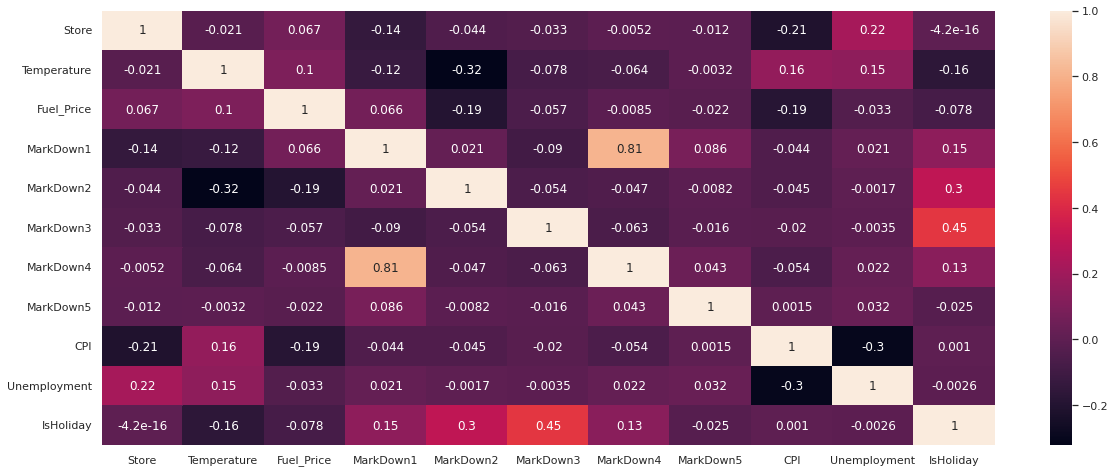

In [28]:
fig, xl = plt.subplots(figsize=(20, 8))
xl=sns.heatmap(raw_features.corr(),annot=True)
plt.show()

In [29]:
"""fig, ax = plt.subplots(figsize=(20, 8))
ax=sns.heatmap(features_scenario1.corr(),annot=True)
plt.show()"""

'fig, ax = plt.subplots(figsize=(20, 8))\nax=sns.heatmap(features_scenario1.corr(),annot=True)\nplt.show()'

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

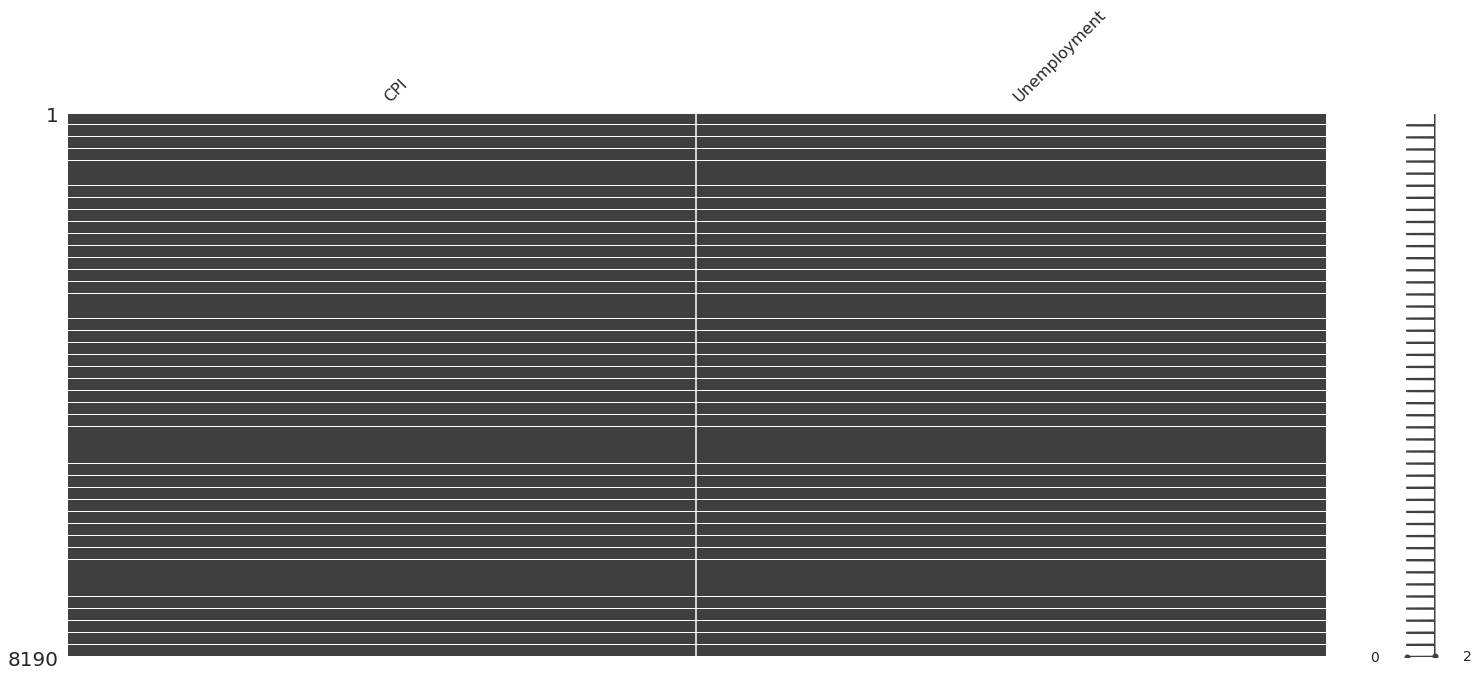

In [30]:
from google.colab import files
fig=msno.matrix(raw_features[['CPI','Unemployment']])
figs=fig.get_figure()
figs.savefig("myImagePDF.pdf", format="pdf", bbox_inches="tight")
files.download("myImagePDF.pdf")

In [31]:
# from the above visualization we can actually see that CPI and Unemployment have been missing at the same exact rows thus leading us to remove them, due to a very minor loss of data
features_drop=raw_features.dropna(subset=["CPI"])

In [32]:
features_drop.shape

(7605, 12)

In [33]:
features_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7605 entries, 0 to 8176
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Store         7605 non-null   int64  
 1   Date          7605 non-null   object 
 2   Temperature   7605 non-null   float64
 3   Fuel_Price    7605 non-null   float64
 4   MarkDown1     3449 non-null   float64
 5   MarkDown2     2441 non-null   float64
 6   MarkDown3     3084 non-null   float64
 7   MarkDown4     2974 non-null   float64
 8   MarkDown5     3465 non-null   float64
 9   CPI           7605 non-null   float64
 10  Unemployment  7605 non-null   float64
 11  IsHoliday     7605 non-null   bool   
dtypes: bool(1), float64(9), int64(1), object(1)
memory usage: 720.4+ KB


In [34]:
features_drop["Date"]=pd.to_datetime(features_drop["Date"])

In [35]:
features_drop.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7605 entries, 0 to 8176
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         7605 non-null   int64         
 1   Date          7605 non-null   datetime64[ns]
 2   Temperature   7605 non-null   float64       
 3   Fuel_Price    7605 non-null   float64       
 4   MarkDown1     3449 non-null   float64       
 5   MarkDown2     2441 non-null   float64       
 6   MarkDown3     3084 non-null   float64       
 7   MarkDown4     2974 non-null   float64       
 8   MarkDown5     3465 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     7605 non-null   bool          
dtypes: bool(1), datetime64[ns](1), float64(9), int64(1)
memory usage: 720.4 KB


In [36]:
split_date = '2011-11-25 23:00:00'


In [37]:
type(split_date)

str

In [38]:
df_training = features_drop.loc[features_drop['Date'] <= split_date]
df_test = features_drop.loc[features_drop['Date'] > split_date]

In [39]:
df_test.shape

(3330, 12)

In [40]:
df_test.head(100)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
95,1,2011-12-02,48.91,3.172,5629.51,68.00,1398.11,2084.64,20475.32,218.714733,7.866,False
96,1,2011-12-09,43.93,3.158,4640.65,19.00,105.02,3639.42,14461.82,218.961846,7.866,False
97,1,2011-12-16,51.63,3.159,5011.32,67.00,347.37,225.79,4011.37,219.179453,7.866,False
98,1,2011-12-23,47.96,3.112,2725.36,40.48,634.70,24.90,2739.43,219.357722,7.866,False
99,1,2011-12-30,44.55,3.129,5762.10,46011.38,260.36,983.65,4735.78,219.535990,7.866,True
...,...,...,...,...,...,...,...,...,...,...,...,...
298,2,2012-04-27,67.20,3.814,3076.68,NaN,38.32,108.71,2708.90,221.255812,6.891,False
299,2,2012-05-04,76.73,3.749,23731.47,NaN,78.09,7931.42,4443.52,221.309517,6.891,False
300,2,2012-05-11,73.87,3.688,16519.50,NaN,117.38,5131.02,3634.25,221.363221,6.891,False
301,2,2012-05-18,71.27,3.630,9262.12,NaN,42.67,3694.80,4612.01,221.380331,6.891,False


In [41]:
features_scenario1=df_test

In [42]:
4275+3330

7605

In [43]:
features_drop.shape

(7605, 12)

In [44]:
features_scenario1.isna().sum()

Store              0
Date               0
Temperature        0
Fuel_Price         0
MarkDown1         15
MarkDown2       1013
MarkDown3        370
MarkDown4        466
MarkDown5          0
CPI                0
Unemployment       0
IsHoliday          0
dtype: int64

In [45]:
raw_features_merge_with_store=raw_features.merge(raw_stores,how="inner",on="Store")

In [46]:
raw_features_merge_with_store.head(10)

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Type,Size
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False,A,151315
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True,A,151315
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False,A,151315
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False,A,151315
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False,A,151315
5,1,2010-03-12,57.79,2.667,NaN,NaN,NaN,NaN,NaN,211.380643,8.106,False,A,151315
6,1,2010-03-19,54.58,2.720,NaN,NaN,NaN,NaN,NaN,211.215635,8.106,False,A,151315
7,1,2010-03-26,51.45,2.732,NaN,NaN,NaN,NaN,NaN,211.018042,8.106,False,A,151315
8,1,2010-04-02,62.27,2.719,NaN,NaN,NaN,NaN,NaN,210.820450,7.808,False,A,151315
9,1,2010-04-09,65.86,2.770,NaN,NaN,NaN,NaN,NaN,210.622857,7.808,False,A,151315


In [47]:
featuresdrop_merge_with_store=features_drop.merge(raw_stores,how="inner",on="Store")

In [48]:
featuresdrop_merge_with_store.describe()

,Store,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,7605.000000,7605.000000,7605.000000,3449.000000,2441.000000,3084.000000,2974.000000,3465.000000,7605.000000,7605.000000,7605.00000
mean,23.000000,58.297325,3.389624,7346.686886,3918.187853,2026.774066,3349.993410,4257.267299,172.460809,7.826821,130287.60000
std,12.988027,18.709862,0.441461,9724.747757,9522.212782,12185.103596,7180.599985,14050.353680,39.738346,1.877259,63116.26787
min,1.000000,-7.290000,2.472000,-2781.450000,-265.760000,-179.260000,0.220000,-185.170000,126.064000,3.684000,34875.00000
25%,12.000000,44.720000,3.001000,1673.310000,57.960000,5.735000,282.730000,1472.860000,132.364839,6.634000,70713.00000
50%,23.000000,59.250000,3.494000,4879.580000,345.500000,30.370000,1108.435000,2772.050000,182.764003,7.806000,126512.00000
75%,34.000000,72.620000,3.742000,9264.480000,3128.740000,137.517500,3162.400000,4893.310000,213.932412,8.567000,202307.00000
max,45.000000,100.140000,4.468000,103184.980000,104519.540000,149483.310000,67474.850000,771448.100000,228.976456,14.313000,219622.00000


In [49]:
featuresdrop_merge_with_store.info(
    
)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7605 entries, 0 to 7604
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         7605 non-null   int64         
 1   Date          7605 non-null   datetime64[ns]
 2   Temperature   7605 non-null   float64       
 3   Fuel_Price    7605 non-null   float64       
 4   MarkDown1     3449 non-null   float64       
 5   MarkDown2     2441 non-null   float64       
 6   MarkDown3     3084 non-null   float64       
 7   MarkDown4     2974 non-null   float64       
 8   MarkDown5     3465 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     7605 non-null   bool          
 12  Type          7605 non-null   object        
 13  Size          7605 non-null   int64         
dtypes: bool(1), datetime64[ns](1), float64(9), int64(2), object(1)
memory usage: 839.2+ KB


In [50]:
featuresdrop_merge_with_store['MarkDown1'] = featuresdrop_merge_with_store['MarkDown1'].replace(np.nan, 0)
featuresdrop_merge_with_store['MarkDown2'] = featuresdrop_merge_with_store['MarkDown2'].replace(np.nan, 0)
featuresdrop_merge_with_store['MarkDown3'] = featuresdrop_merge_with_store['MarkDown3'].replace(np.nan, 0)
featuresdrop_merge_with_store['MarkDown4'] = featuresdrop_merge_with_store['MarkDown4'].replace(np.nan, 0)
featuresdrop_merge_with_store['MarkDown5'] = featuresdrop_merge_with_store['MarkDown5'].replace(np.nan, 0)

In [51]:
features_scenario_dropand0=featuresdrop_merge_with_store

In [52]:
featuresdrop_merge_with_store.shape


(7605, 14)

In [53]:
print("Shape of stores data Set: ",raw_stores.shape)
print("Shape of features data Set: ",features_drop.shape)
print("Shape of data data Set: ",raw_data.shape)

Shape of stores data Set:  (45, 3)
Shape of features data Set:  (7605, 12)
Shape of data data Set:  (421570, 5)


In [54]:
print("Shape of merged data",featuresdrop_merge_with_store.shape)

Shape of merged data (7605, 14)


In [55]:
#This is the scenario where CPI and Unemployment Null values have been dropped and nas have been converted to 0 for markdown
features_scenario_dropand0.shape 

(7605, 14)

In [56]:
#lets check how the train dataset is like 

In [57]:
raw_data.head(10)

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False
5,1,1,2010-03-12,21043.39,False
6,1,1,2010-03-19,22136.64,False
7,1,1,2010-03-26,26229.21,False
8,1,1,2010-04-02,57258.43,False
9,1,1,2010-04-09,42960.91,False


In [58]:
raw_data.shape

(421570, 5)

In [59]:
# by above description  we can see that the data we have in the training file is for weekly sales 
# lets merge the data set with the processesd features dataset  

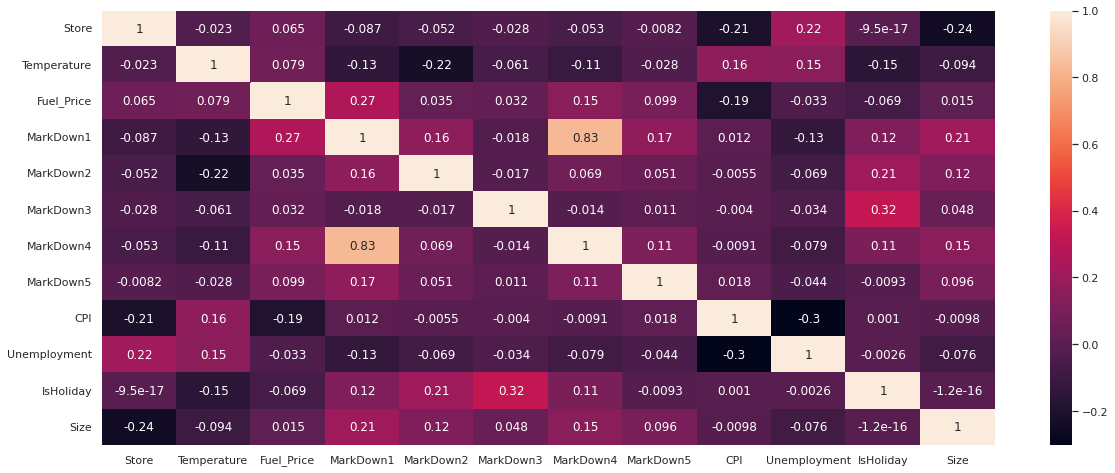

In [60]:
fig, xl = plt.subplots(figsize=(20, 8))
sns.heatmap(features_scenario_dropand0.corr(),annot=True)
plt.show()

In [61]:
#As we have already have one dataset in a datetime format for "date" feature we are converting the other one to datetime format too !!

raw_data["Date"]=pd.to_datetime(raw_data["Date"])

In [62]:
df1=raw_data.merge(features_scenario_dropand0,on=['Store','IsHoliday','Date'],how='inner')

In [63]:
print("Shape of Merged data Set: Inner",df1.shape)

Shape of Merged data Set: Inner (421570, 16)


In [64]:
df1.to_csv("Scenario1.csv")
files.download('Scenario1.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [65]:
df1.shape

(421570, 16)

In [66]:
df1.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
dtype: int64

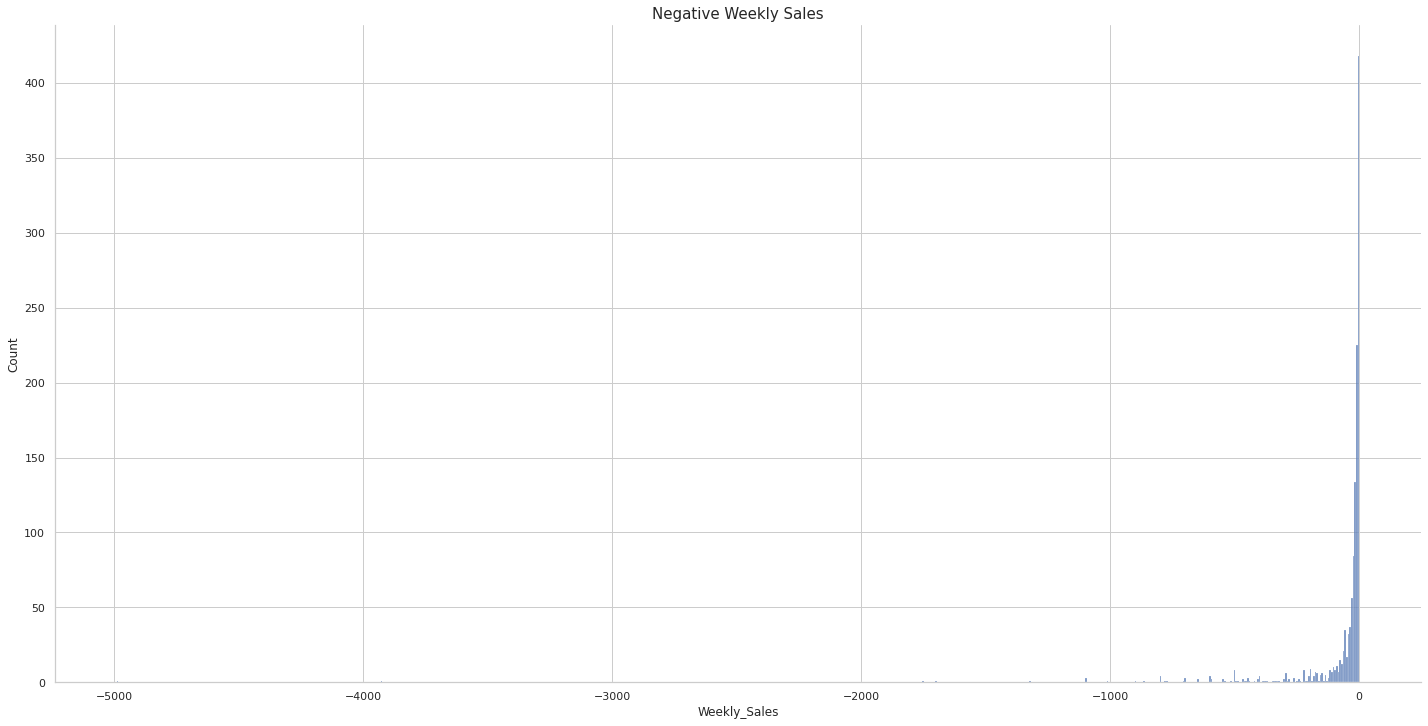

In [67]:
vis = df1["Weekly_Sales"][df1.Weekly_Sales < 0]
sns.displot(vis,height=10,aspect=2)
plt.title("Negative Weekly Sales", fontsize=15)
plt.savefig('negative_weekly_sales.png',bbox_inches="tight",dpi=1500)
plt.show()

In [68]:
df1.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000,421570.000000
mean,22.200546,44.260317,15981.258123,60.090059,3.361027,2590.074819,879.974298,468.087665,1083.132268,1662.772385,171.201947,7.960289,136727.915739
std,12.785297,30.492054,22711.183519,18.447931,0.458515,6052.385934,5084.538801,5528.873453,3894.529945,4207.629321,39.159276,1.863296,60980.583328
min,1.000000,1.000000,-4988.940000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2079.650000,46.680000,2.933000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7612.030000,62.090000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.318780,7.866000,140167.000000
75%,33.000000,74.000000,20205.852500,74.280000,3.738000,2809.050000,2.200000,4.540000,425.290000,2168.040000,212.416993,8.572000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [69]:
files.download('negative_weekly_sales.png')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [70]:
hellss=df1.copy()

In [71]:
hells=df1[['Weekly_Sales','MarkDown2','MarkDown3']]

In [72]:
hells.describe().loc[['min']].T

,min
Weekly_Sales,-4988.94
MarkDown2,-265.76
MarkDown3,-29.10


In [73]:
#from the above we can find two anamolies that there are min values with -ve values for the features named "Weekly Sales","MarkDown2", "MarkDown3"

In [74]:
df1[(df1['Weekly_Sales'] <= 0)]

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
188,1,47,2010-02-19,-863.00,False,39.93,2.514,0.00,0.00,0.00,0.00,0.00,211.289143,8.106,A,151315
406,1,47,2010-03-12,-698.00,False,57.79,2.667,0.00,0.00,0.00,0.00,0.00,211.380643,8.106,A,151315
2549,1,47,2010-10-08,-58.00,False,63.93,2.633,0.00,0.00,0.00,0.00,0.00,211.746754,7.838,A,151315
3632,1,54,2011-01-21,-50.00,False,44.04,3.016,0.00,0.00,0.00,0.00,0.00,211.827234,7.742,A,151315
4132,1,47,2011-03-11,0.00,False,53.56,3.459,0.00,0.00,0.00,0.00,0.00,214.111056,7.742,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420066,45,49,2012-05-25,-4.97,False,67.21,3.798,5370.39,0.00,361.22,1287.62,2461.81,191.002810,8.567,B,118221
420403,45,49,2012-06-29,-34.00,False,75.22,3.506,3291.36,425.60,0.00,314.88,2255.34,191.099246,8.567,B,118221
420736,45,49,2012-08-03,-1.91,False,76.58,3.654,24853.05,39.56,17.96,11142.69,2768.32,191.164090,8.684,B,118221
421007,45,54,2012-08-31,0.00,False,75.09,3.867,23641.30,6.00,92.93,6988.31,3992.13,191.461281,8.684,B,118221


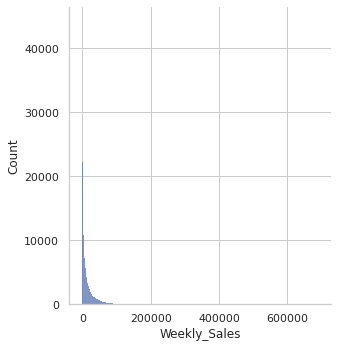

In [75]:
#So to correct this lets check the distribution of weekly sales to get an understanding of how to impute the -ve values
sns.displot(df1['Weekly_Sales'])

In [76]:
outlier_max=df1["Weekly_Sales"].quantile(0.95)

In [77]:
outlier_min=df1["Weekly_Sales"].quantile(0.05)


In [78]:
outlier_min

59.974500000000006

In [79]:
df1.shape

(421570, 16)

In [80]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Store,421570.0,22.200546,12.785297,1.000,11.000000,22.00000,33.000000,45.000000
Dept,421570.0,44.260317,30.492054,1.000,18.000000,37.00000,74.000000,99.000000
Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.940,2079.650000,7612.03000,20205.852500,693099.360000
Temperature,421570.0,60.090059,18.447931,-2.060,46.680000,62.09000,74.280000,100.140000
Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933000,3.45200,3.738000,4.468000
MarkDown1,421570.0,2590.074819,6052.385934,0.000,0.000000,0.00000,2809.050000,88646.760000
MarkDown2,421570.0,879.974298,5084.538801,-265.760,0.000000,0.00000,2.200000,104519.540000
MarkDown3,421570.0,468.087665,5528.873453,-29.100,0.000000,0.00000,4.540000,141630.610000
MarkDown4,421570.0,1083.132268,3894.529945,0.000,0.000000,0.00000,425.290000,67474.850000
MarkDown5,421570.0,1662.772385,4207.629321,0.000,0.000000,0.00000,2168.040000,108519.280000


In [81]:
#RemoveAnomalies
df111=df1[(df1["Weekly_Sales"]>0)]         
df111.shape

(420212, 16)

In [82]:
df111=df111[(df111["MarkDown2"]>=0)]  
df111.shape 

(418910, 16)

In [83]:
df111=df111[(df111["MarkDown3"]>=0)]  
df111.shape 

(418654, 16)

In [84]:
df111.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [85]:
#After Removing the anamolies
df111.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000,418654.000000
mean,22.197354,44.242241,16028.664965,60.052348,3.359308,2575.945153,882.156489,470.476283,1080.156246,1654.468456,171.202468,7.961483,136684.968430
std,12.790526,30.510172,22726.308043,18.454874,0.458387,6056.919377,5086.078731,5544.292474,3901.826427,4207.467593,39.158998,1.864320,61010.768249
min,1.000000,1.000000,0.010000,-2.060000,2.472000,0.000000,0.000000,0.000000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,18.000000,2118.287500,46.660000,2.931000,0.000000,0.000000,0.000000,0.000000,0.000000,132.022667,6.891000,93638.000000
50%,22.000000,37.000000,7659.405000,62.060000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.350989,7.866000,140167.000000
75%,33.000000,74.000000,20267.445000,74.250000,3.735000,2753.900000,2.630000,4.360000,415.360000,2146.940000,212.412888,8.567000,202505.000000
max,45.000000,99.000000,693099.360000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


In [86]:
df1

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421566,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421567,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221
421568,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221


In [87]:
df11=df1[(df1["Weekly_Sales"]<outlier_max) & (df1["Weekly_Sales"]>outlier_min)]

In [88]:
df11.describe()

,Store,Dept,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size
count,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000,379412.000000
mean,22.099649,43.008221,12772.788110,59.907980,3.359936,2597.876727,884.764318,457.445892,1082.140291,1651.734646,171.384283,7.955339,136806.898203
std,12.714089,30.180710,13820.034321,18.457643,0.458989,6041.121725,5073.617672,5422.571084,3881.167694,4157.208046,39.097377,1.864337,60120.237747
min,1.000000,1.000000,59.980000,-2.060000,2.472000,0.000000,-265.760000,-29.100000,0.000000,0.000000,126.064000,3.879000,34875.000000
25%,11.000000,17.000000,2488.280000,46.540000,2.931000,0.000000,0.000000,0.000000,0.000000,0.000000,132.364839,6.885000,93638.000000
50%,22.000000,35.000000,7612.030000,61.900000,3.452000,0.000000,0.000000,0.000000,0.000000,0.000000,182.544590,7.866000,140167.000000
75%,32.000000,72.000000,18295.685000,74.150000,3.738000,2920.430000,2.650000,4.460000,445.470000,2169.340000,212.571112,8.567000,202505.000000
max,45.000000,99.000000,61201.830000,100.140000,4.468000,88646.760000,104519.540000,141630.610000,67474.850000,108519.280000,227.232807,14.313000,219622.000000


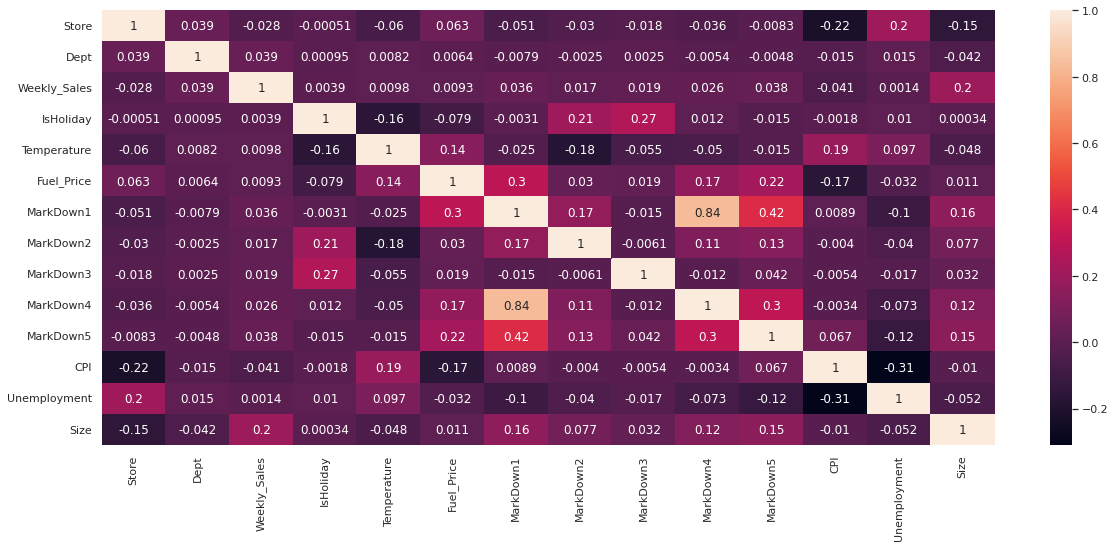

In [89]:
fig, xl = plt.subplots(figsize=(20, 8))
sns.heatmap(df11.corr(),annot=True)
plt.show()

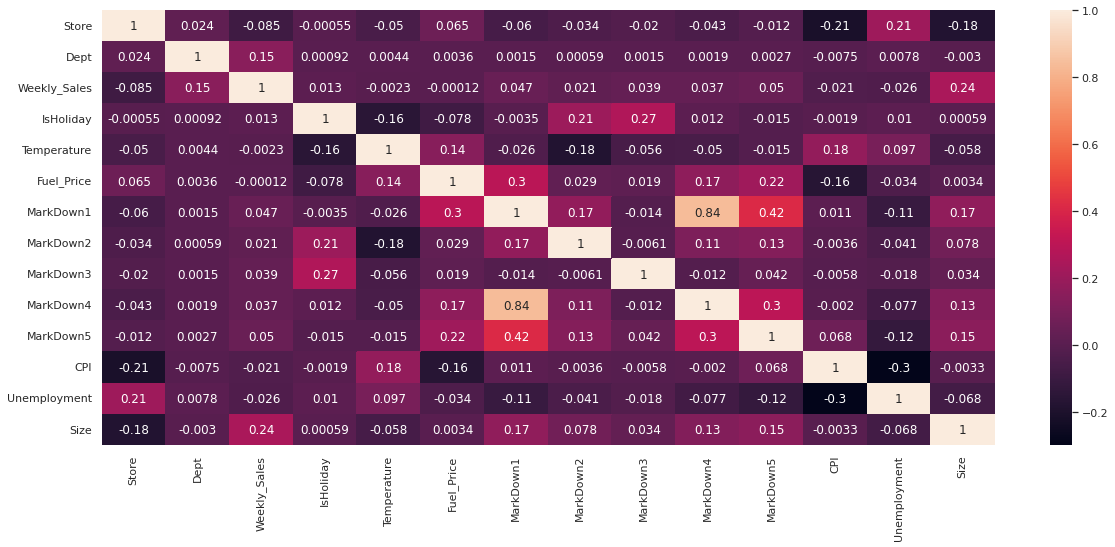

In [90]:
fig, xl = plt.subplots(figsize=(20, 8))
sns.heatmap(df1.corr(),annot=True)
plt.show()

In [91]:
df111.to_csv("times.csv")

In [92]:
testing_df=pd.read_csv("times.csv",parse_dates=["Date"])

In [93]:
del testing_df[testing_df.columns[0]]

In [94]:
testing_df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


In [95]:
#testing_df['Dates'] = testing_df['Date']


In [96]:
"""fig, xl = plt.subplots(figsize=(20, 20))
testing_df.Weekly_Sales.plot()
plt.show()"""

'fig, xl = plt.subplots(figsize=(20, 20))\ntesting_df.Weekly_Sales.plot()\nplt.show()'

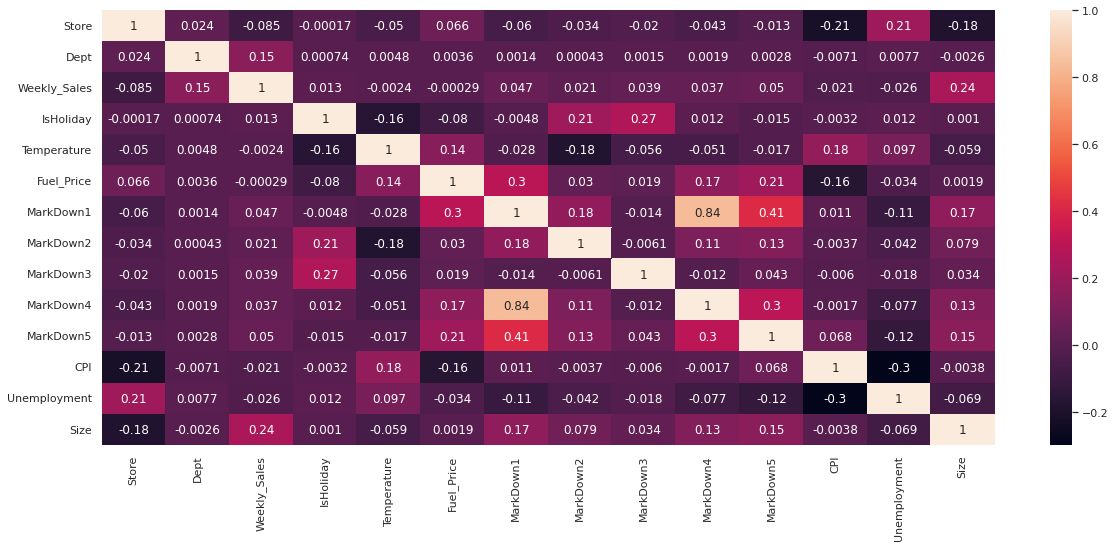

In [97]:
fig, xl = plt.subplots(figsize=(20, 8))
sns.heatmap(testing_df.corr(),annot=True)
plt.show()

In [98]:
testing_df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315


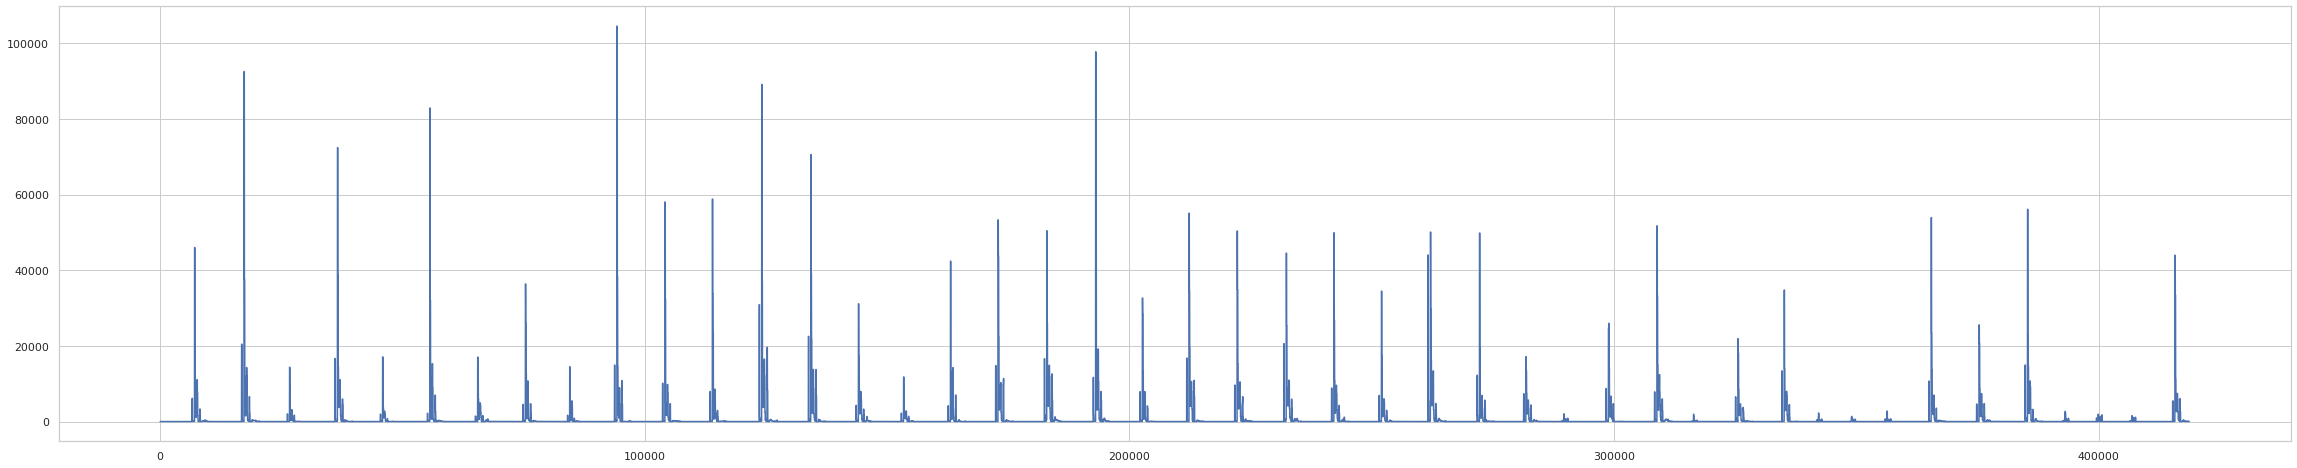

In [99]:
fig, xl = plt.subplots(figsize=(40, 8))
testing_df.MarkDown2.plot()
plt.show()

In [100]:
#Feature Engineering
#Creating two columns to extract the week and year from the data
testing_df['Week'] = pd.to_datetime(testing_df['Date']).dt.week
testing_df['Year'] = pd.to_datetime(testing_df['Date']).dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [101]:
testing_df['Month']=testing_df["Date"].dt.month

In [102]:
testing_df.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2


In [103]:
#Creating a new dataset just for the weekly sales mean
weekly_sales = testing_df.groupby(['Year','Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2010 = testing_df.loc[testing_df['Year']==2010].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2011 = testing_df.loc[testing_df['Year']==2011].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})
weekly_sales2012 = testing_df.loc[testing_df['Year']==2012].groupby(['Week']).agg({'Weekly_Sales': ['mean', 'median']})


In [104]:
print('total week',weekly_sales.shape)
print('total week 2010',weekly_sales2010.shape)
print('total week 2011',weekly_sales2011.shape)
print('total week 2012',weekly_sales2012.shape)

total week (143, 2)
total week 2010 (48, 2)
total week 2011 (52, 2)
total week 2012 (43, 2)


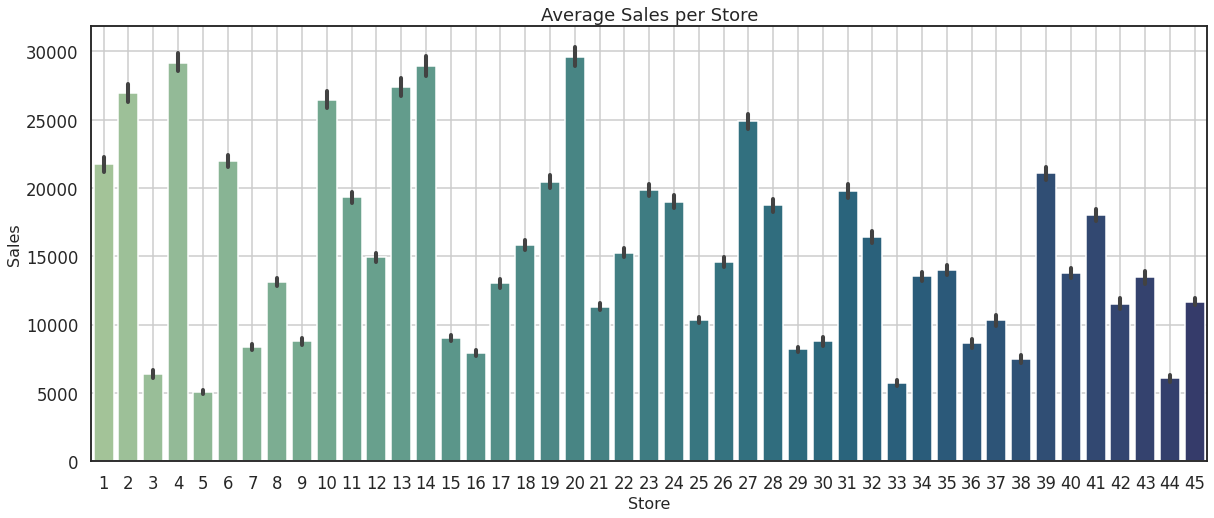

In [105]:
plt.figure(figsize=(20,8))
sns.set(style="white", context="talk")
sns.barplot(x='Store',y='Weekly_Sales',palette= "crest", data=testing_df)
plt.grid()
plt.title('Average Sales per Store', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Store', fontsize=16)
plt.savefig('avgsalesperstore.png',bbox_inches="tight",dpi=1500)
plt.show()

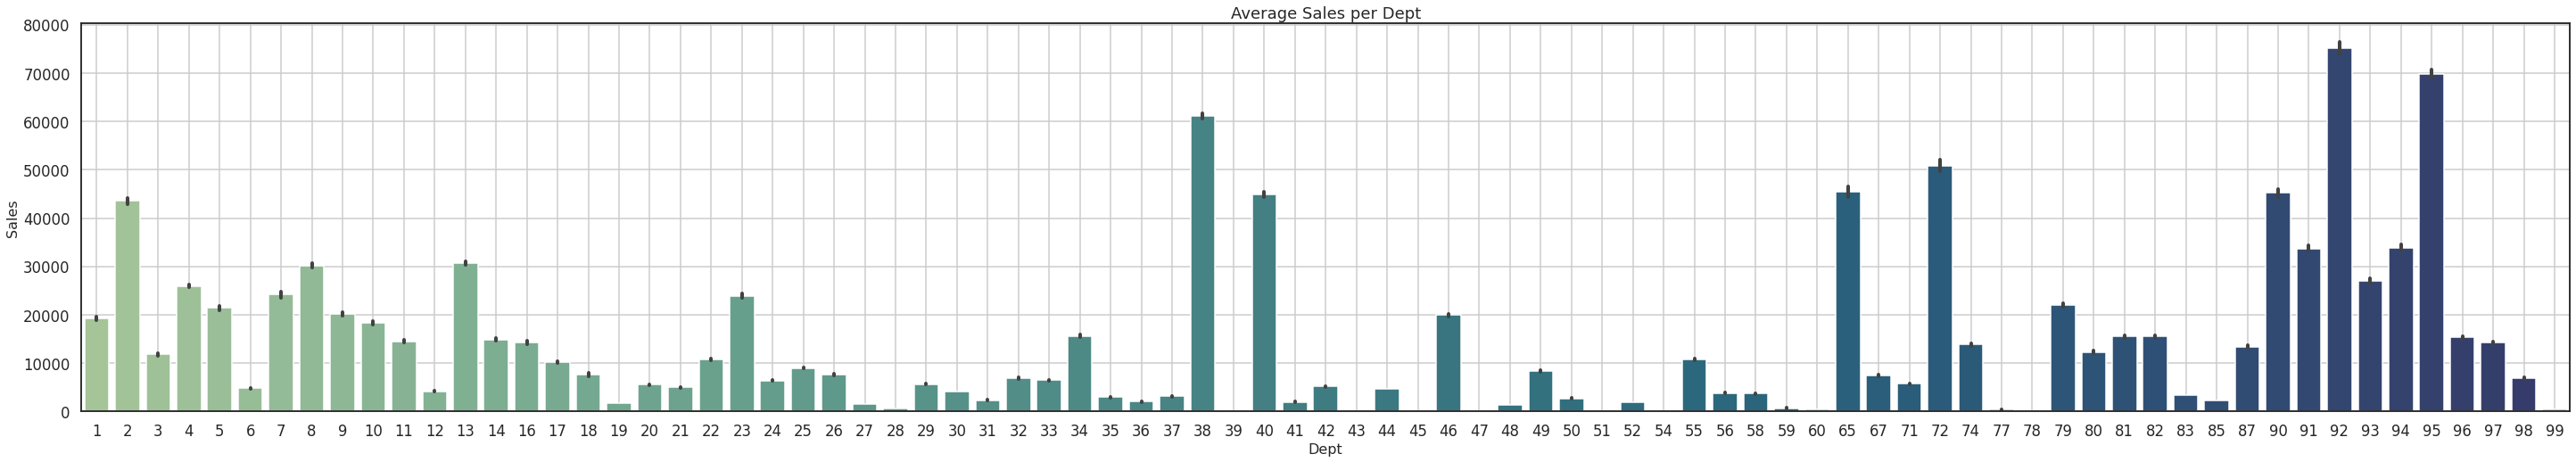

In [106]:
plt.figure(figsize=(50,8))
sns.set(style="white", context="talk")
sns.barplot(x='Dept',y='Weekly_Sales',palette= "crest", data=testing_df)
plt.grid()
plt.title('Average Sales per Dept', fontsize=18)
plt.ylabel('Sales', fontsize=16)
plt.xlabel('Dept', fontsize=16)
#plt.savefig('avgsalesperdept.png',bbox_inches="tight",dpi=1500)
plt.show()

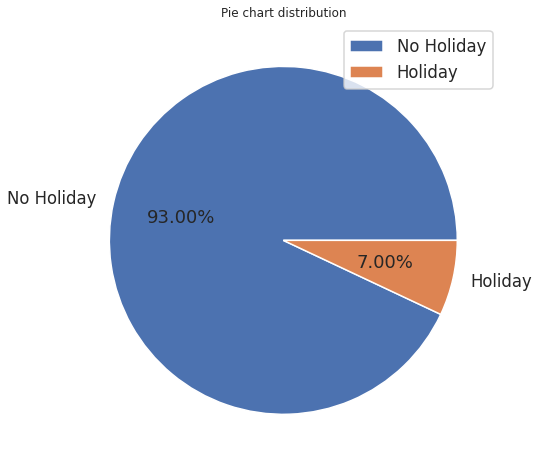

In [107]:
plt.figure(figsize=(8,8))
plt.pie(testing_df['IsHoliday'].value_counts(),labels=['No Holiday','Holiday'],autopct='%0.2f%%')
plt.title("Pie chart distribution",fontsize=12)
plt.legend()
plt.savefig('holidayDist.png',bbox_inches="tight",dpi=600)
plt.show()

In [108]:

#weekly sales for 2011
#df = weekly_sales2010
#fig = px.line(df1, x='Week', y='mean')

#fig.show()

In [109]:
#Downloading of the csv files to do data processing in excel to create a plot
"""weekly_sales2010.to_csv('weekly.csv')
weekly_sales2011.to_csv('weekly1.csv')
weekly_sales2012.to_csv('weekly2.csv')"""

"weekly_sales2010.to_csv('weekly.csv')\nweekly_sales2011.to_csv('weekly1.csv')\nweekly_sales2012.to_csv('weekly2.csv')"

In [110]:
"""weekly_sales.to_csv('week.csv')"""

"weekly_sales.to_csv('week.csv')"

In [111]:
"""files.download('week.csv')"""

"files.download('week.csv')"

In [112]:
#Reading the modeled files
"""files.download('weekly2.csv')
df2=pd.read_csv('weekly2.csv')"""

"files.download('weekly2.csv')\ndf2=pd.read_csv('weekly2.csv')"

In [113]:
#Weekly Sales comparision using plotly multiple years
weeklysales_comparision=pd.read_csv('weekly_merge.csv')
fig = px.line(weeklysales_comparision, x='Week', y=weeklysales_comparision.columns[1:4])
fig.show()

In [114]:
total_weeklysales=pd.read_csv('week.csv')


In [115]:
"""fig = px.line(total_weeklysales, x='Year', y=total_weeklysales.columns[2:3])
fig.show()"""

"fig = px.line(total_weeklysales, x='Year', y=total_weeklysales.columns[2:3])\nfig.show()"

In [116]:
total_weeklysales.columns[2:4]

Index(['mean', 'median'], dtype='object')

In [117]:
testing_df.shape

(418654, 19)

In [118]:
"""testing_df['ds']=testing_df['Date']
testing_df['y']=testing_df['Weekly_Sales']"""

"testing_df['ds']=testing_df['Date']\ntesting_df['y']=testing_df['Weekly_Sales']"

In [119]:
"""m=Prophet()
model=m.fit(testing_df)"""

'm=Prophet()\nmodel=m.fit(testing_df)'

In [120]:
"""
future=m.make_future_dataframe(periods=100)
forecast=m.predict(future)
forecast.tail()
plot1=m.plot(forecast)
"""


'\nfuture=m.make_future_dataframe(periods=100)\nforecast=m.predict(future)\nforecast.tail()\nplot1=m.plot(forecast)\n'

In [121]:
"""weekly_sale2010 = testing_df.loc[testing_df['Year']==2010].groupby(['Week'])
traindf=pd.read_csv("train.csv")
trains=traindf.groupby(['Date'])
traindf.head(2)"""

'weekly_sale2010 = testing_df.loc[testing_df[\'Year\']==2010].groupby([\'Week\'])\ntraindf=pd.read_csv("train.csv")\ntrains=traindf.groupby([\'Date\'])\ntraindf.head(2)'

In [122]:
#files.download("holidayDist.png")

In [123]:
testing_df.head(2)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Week,Year,Month
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,8.106,A,151315,5,2010,2


In [124]:
testing_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418654 entries, 0 to 418653
Data columns (total 19 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         418654 non-null  int64         
 1   Dept          418654 non-null  int64         
 2   Date          418654 non-null  datetime64[ns]
 3   Weekly_Sales  418654 non-null  float64       
 4   IsHoliday     418654 non-null  bool          
 5   Temperature   418654 non-null  float64       
 6   Fuel_Price    418654 non-null  float64       
 7   MarkDown1     418654 non-null  float64       
 8   MarkDown2     418654 non-null  float64       
 9   MarkDown3     418654 non-null  float64       
 10  MarkDown4     418654 non-null  float64       
 11  MarkDown5     418654 non-null  float64       
 12  CPI           418654 non-null  float64       
 13  Unemployment  418654 non-null  float64       
 14  Type          418654 non-null  object        
 15  Size          418

In [125]:
stats = testing_df.groupby(['Store', 'Dept']).Weekly_Sales.agg(['max', 'min', 'mean', 'median', 'std']).reset_index()


In [126]:
stats.isnull().sum()

Store      0
Dept       0
max        0
min        0
mean       0
median     0
std       40
dtype: int64

In [127]:
stats.shape

(3323, 7)

In [128]:
stats_merged_data=pd.merge(left=testing_df,right=stats,how='left',on=['Store','Dept'])

In [129]:
stats_merged_data.shape

(418654, 24)

In [130]:
stats_merged_data.head(1)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Type,Size,Week,Year,Month,max,min,mean,median,std
0,1,1,2010-02-05,24924.5,False,42.31,2.572,0.0,0.0,0.0,...,A,151315,5,2010,2,57592.12,14537.37,22513.322937,18535.48,9854.349032


In [131]:
stats_merged_data["Total Deal"]=stats_merged_data['MarkDown1']+stats_merged_data['MarkDown2']+stats_merged_data['MarkDown3']+stats_merged_data['MarkDown4']+stats_merged_data['MarkDown5']

In [132]:
stats_merged_data.shape

(418654, 25)

In [133]:
stats_merged_data.isna().sum()

Store            0
Dept             0
Date             0
Weekly_Sales     0
IsHoliday        0
Temperature      0
Fuel_Price       0
MarkDown1        0
MarkDown2        0
MarkDown3        0
MarkDown4        0
MarkDown5        0
CPI              0
Unemployment     0
Type             0
Size             0
Week             0
Year             0
Month            0
max              0
min              0
mean             0
median           0
std             40
Total Deal       0
dtype: int64

In [134]:
stats_merged_data=stats_merged_data.dropna()

In [135]:
stats_merged_data.isna().sum()

Store           0
Dept            0
Date            0
Weekly_Sales    0
IsHoliday       0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
Week            0
Year            0
Month           0
max             0
min             0
mean            0
median          0
std             0
Total Deal      0
dtype: int64

In [136]:
stats_merged_data_dateless=stats_merged_data.drop('Date',axis=1)

In [137]:
partial_dataset=stats_merged_data_dateless[['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5','Weekly_Sales']]

In [138]:
partial_dataset.shape

(418614, 6)

One Hot Encoding 

In [139]:
"""from pyod.models.knn import KNN
KNN_model = KNN(contamination=0.01)
KNN_model.fit(partial_dataset)

outlier_labels = KNN_model.labels_
number_of_outliers = len(outlier_labels[outlier_labels == 1])
print(number_of_outliers)
outliers = partial_dataset.iloc[outlier_labels == 1]
outliers"""

'from pyod.models.knn import KNN\nKNN_model = KNN(contamination=0.01)\nKNN_model.fit(partial_dataset)\n\noutlier_labels = KNN_model.labels_\nnumber_of_outliers = len(outlier_labels[outlier_labels == 1])\nprint(number_of_outliers)\noutliers = partial_dataset.iloc[outlier_labels == 1]\noutliers'

In [140]:
stats_merged_data=stats_merged_data.set_index('Date')

In [141]:
dfs=stats_merged_data[['Store','Dept','Type']]

In [141]:
stats_merged_data.shape

(418614, 24)

In [142]:
dfs

,Store,Dept,Type
Date,,,
2010-02-05,1,1,A
2010-02-05,1,2,A
2010-02-05,1,3,A
2010-02-05,1,4,A
2010-02-05,1,5,A
...,...,...,...
2012-10-26,45,93,B
2012-10-26,45,94,B
2012-10-26,45,95,B


In [143]:
dfa=pd.get_dummies(dfs,columns=['Store','Dept','Type'])

In [144]:
dfa.shape

(418614, 129)

In [145]:
final_df=pd.concat([stats_merged_data,dfa],axis=1)

In [146]:
final_df=final_df.drop(['Store','Dept','Type'],axis=1)

In [147]:
final_df.shape

(418614, 150)

In [148]:
final_df.head(1)

,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,...,Dept_93,Dept_94,Dept_95,Dept_96,Dept_97,Dept_98,Dept_99,Type_A,Type_B,Type_C
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,24924.5,False,42.31,2.572,0.0,0.0,0.0,0.0,0.0,211.096358,...,0,0,0,0,0,0,0,1,0,0


In [149]:
cols = ['Weekly_Sales','Size','Temperature','Fuel_Price','CPI','Unemployment','Total Deal','max','min','mean','median','std','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5']

In [150]:
"""minmaxdata=final_df[cols]
minmaxdata.shape
final_df.shape
scaler=MinMaxScaler(feature_range=(0,1))
def norm(data,cols):
  for i in cols:
    x = data[i]
    x = np.array(x)
    data[i] = scaler.fit_transform(x.reshape(len(x),1))
  return data
norm_final_data = norm(final_df,cols)
norm_final_data.shape
correlation=norm_final_data[cols]
fig, xl = plt.subplots(figsize=(20, 8))
sns.heatmap(norm_final_data[cols],annot=True)
plt.show()
features = norm_final_data.columns.difference(['Weekly_Sales'])
features"""

features=final_df.columns.difference(['Weekly_Sales'])

#Feature Importance

In [151]:
from sklearn.ensemble import RandomForestRegressor

In [152]:
radm_clf = RandomForestRegressor(oob_score=True,n_estimators=23)
radm_clf.fit(final_df[features], final_df['Weekly_Sales'])

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:564: UserWarning:

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.



RandomForestRegressor(n_estimators=23, oob_score=True)

In [153]:
indices = np.argsort(radm_clf.feature_importances_)[::-1]
feature_list = pd.DataFrame(columns = ['rank', 'feature', 'importance'])
for f in range(final_df[features].shape[1]):
    feature_list.loc[f] = [f+1,
                           final_df[features].columns[indices[f]],
                           radm_clf.feature_importances_[indices[f]]]

feature_list

,rank,feature,importance
0,1,mean,8.881347e-01
1,2,Week,2.345770e-02
2,3,median,1.824502e-02
3,4,max,1.339030e-02
4,5,std,7.639001e-03
...,...,...,...
144,145,Dept_51,1.081464e-10
145,146,Dept_45,9.074737e-11
146,147,Dept_78,1.083253e-12
147,148,Dept_39,5.499666e-14


In [154]:
x=feature_list.loc[0:22,['feature']]
x=x['feature'].tolist()
print(x)

['mean', 'Week', 'median', 'max', 'std', 'Temperature', 'CPI', 'min', 'Fuel_Price', 'Month', 'MarkDown3', 'Unemployment', 'Dept_72', 'IsHoliday', 'MarkDown4', 'MarkDown5', 'MarkDown2', 'Dept_7', 'MarkDown1', 'Total Deal', 'Dept_3', 'Size', 'Dept_16']


# Linear Regression


In [155]:
X=final_df[x]
Target=final_df['Weekly_Sales']
df=pd.concat([X,Target],axis=1)

In [156]:
df

,mean,Week,median,max,std,Temperature,CPI,min,Fuel_Price,Month,...,MarkDown4,MarkDown5,MarkDown2,Dept_7,MarkDown1,Total Deal,Dept_3,Size,Dept_16,Weekly_Sales
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,22513.322937,5,18535.480,57592.12,9854.349032,42.31,211.096358,14537.37,2.572,2,...,0.00,0.00,0.00,0,0.00,0.00,0,151315,0,24924.50
2010-02-05,46102.090420,5,45561.850,65615.36,3440.673222,42.31,211.096358,35819.83,2.572,2,...,0.00,0.00,0.00,0,0.00,0.00,0,151315,0,50605.27
2010-02-05,13150.478042,5,10366.850,51159.17,8708.978853,42.31,211.096358,6165.73,2.572,2,...,0.00,0.00,0.00,0,0.00,0.00,1,151315,0,13740.12
2010-02-05,36964.154476,5,36579.960,47893.23,2930.698313,42.31,211.096358,32497.43,2.572,2,...,0.00,0.00,0.00,0,0.00,0.00,0,151315,0,39954.04
2010-02-05,24257.941119,5,21183.420,85676.09,11330.286495,42.31,211.096358,11570.27,2.572,2,...,0.00,0.00,0.00,0,0.00,0.00,0,151315,0,32229.38
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-10-26,2728.627133,43,2609.360,6551.12,907.044076,58.85,192.308899,1147.54,3.882,10,...,211.94,858.33,58.08,0,4018.91,5247.26,0,118221,0,2487.80
2012-10-26,3690.272090,43,4120.155,7639.88,1852.287364,58.85,192.308899,0.98,3.882,10,...,211.94,858.33,58.08,0,4018.91,5247.26,0,118221,0,5203.31
2012-10-26,52896.166643,43,52417.470,75204.77,5117.961708,58.85,192.308899,41131.42,3.882,10,...,211.94,858.33,58.08,0,4018.91,5247.26,0,118221,0,56017.47


Train Test Split

In [157]:
X=df.drop(['Weekly_Sales'],axis=1)
Y=df.Weekly_Sales

In [158]:
X.head(2)

,mean,Week,median,max,std,Temperature,CPI,min,Fuel_Price,Month,...,IsHoliday,MarkDown4,MarkDown5,MarkDown2,Dept_7,MarkDown1,Total Deal,Dept_3,Size,Dept_16
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-05,22513.322937,5,18535.48,57592.12,9854.349032,42.31,211.096358,14537.37,2.572,2,...,False,0.0,0.0,0.0,0,0.0,0.0,0,151315,0
2010-02-05,46102.090420,5,45561.85,65615.36,3440.673222,42.31,211.096358,35819.83,2.572,2,...,False,0.0,0.0,0.0,0,0.0,0.0,0,151315,0


In [159]:
X.shape

(418614, 23)

In [160]:
Y.head(2)

Date
2010-02-05    24924.50
2010-02-05    50605.27
Name: Weekly_Sales, dtype: float64

In [161]:
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [162]:
lr = LinearRegression(normalize=False)
lr.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:155: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.



LinearRegression(normalize=False)

In [163]:
lr_acc = lr.score(X_test,y_test)

In [164]:
lr_acc

0.8971259197446761

In [165]:
y_pred = lr.predict(X_test)

In [166]:
print("MAE" , mean_absolute_error(y_test, y_pred))
print("MSE" , mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2" , explained_variance_score(y_test, y_pred))

MAE 2795.0313106809454
MSE 53808848.93992298
RMSE 7335.451515750273
R2 0.8971264130717437


In [167]:
test_score = lr.score(X_test, y_test)*100

In [168]:
print(test_score)

89.71259197446761


In [169]:
y_test.head()

Date
2012-04-20     2059.56
2012-03-30    85896.75
2011-07-01    12907.11
2010-08-13    55962.13
2012-08-17    13445.48
Name: Weekly_Sales, dtype: float64

In [170]:
import lightgbm as lgb

In [171]:
model = lgb.LGBMRegressor(n_estimators=2000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=10,
        num_leaves=50,
        min_child_weight=300)

In [172]:
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
             eval_metric='rmse', verbose=20, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[20]	training's l2: 2.36141e+07	training's rmse: 4859.44	valid_1's l2: 2.87596e+07	valid_1's rmse: 5362.8
[40]	training's l2: 1.96011e+07	training's rmse: 4427.31	valid_1's l2: 2.42547e+07	valid_1's rmse: 4924.91
[60]	training's l2: 1.74142e+07	training's rmse: 4173.03	valid_1's l2: 2.18038e+07	valid_1's rmse: 4669.46
[80]	training's l2: 1.58663e+07	training's rmse: 3983.25	valid_1's l2: 2.00074e+07	valid_1's rmse: 4472.96
[100]	training's l2: 1.49935e+07	training's rmse: 3872.14	valid_1's l2: 1.91926e+07	valid_1's rmse: 4380.93
[120]	training's l2: 1.42065e+07	training's rmse: 3769.15	valid_1's l2: 1.83482e+07	valid_1's rmse: 4283.48
[140]	training's l2: 1.35335e+07	training's rmse: 3678.8	valid_1's l2: 1.77153e+07	valid_1's rmse: 4208.96
[160]	training's l2: 1.29695e+07	training's rmse: 3601.31	valid_1's l2: 1.70698e+07	valid_1's rmse: 4131.56
[180]	training's l2: 1.24018e+07	training's rmse: 3521.61	valid_1's l2: 1.65287e

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=10,
              min_child_weight=300, n_estimators=2000, num_leaves=50,
              subsample=0.8)

In [173]:
y_pred=model.predict(X_test)

In [174]:
rmse_test_lightGBM = mean_squared_error(y_test, y_pred) ** 0.5

In [175]:
rmse_test_lightGBM

3260.7942783513163

In [176]:
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

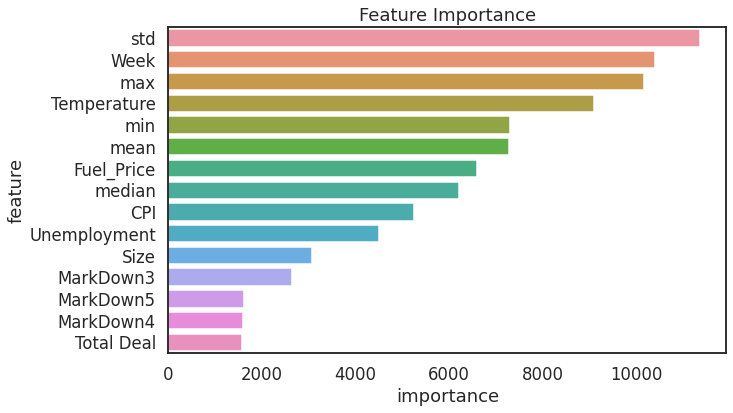

In [177]:
plt.figure(figsize=(10,6))
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(15), x='importance', y='feature');
plt.savefig('fetureImpLightGBM.pdf')

In [178]:
print(y_pred)

[ 2180.09786713 89391.59965152 13038.07148436 ...  7803.96081955
  4138.99334546 66138.62732304]


In [179]:
df2=final_df

In [180]:
dfm=df2[['std','Week','max','Temperature','mean','min','Fuel_Price','median','CPI','Unemployment','Size','MarkDown3','MarkDown5','Total Deal','MarkDown2','Weekly_Sales']]

In [181]:
X=dfm.drop(['Weekly_Sales'],axis=1)
Y=dfm.Weekly_Sales
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=50)

In [182]:
model = lgb.LGBMRegressor(n_estimators=2000,
        learning_rate=0.3,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=10,
        num_leaves=50,
        min_child_weight=300,
        )

In [183]:
model.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
             eval_metric='rmse', verbose=40, early_stopping_rounds=20)

Training until validation scores don't improve for 20 rounds.
[40]	training's l2: 2.18793e+07	training's rmse: 4677.53	valid_1's l2: 2.71843e+07	valid_1's rmse: 5213.86
[80]	training's l2: 1.80305e+07	training's rmse: 4246.23	valid_1's l2: 2.30556e+07	valid_1's rmse: 4801.62
[120]	training's l2: 1.62123e+07	training's rmse: 4026.45	valid_1's l2: 2.14004e+07	valid_1's rmse: 4626.06
[160]	training's l2: 1.49153e+07	training's rmse: 3862.03	valid_1's l2: 2.01133e+07	valid_1's rmse: 4484.78
[200]	training's l2: 1.37877e+07	training's rmse: 3713.18	valid_1's l2: 1.90239e+07	valid_1's rmse: 4361.64
[240]	training's l2: 1.29379e+07	training's rmse: 3596.92	valid_1's l2: 1.83086e+07	valid_1's rmse: 4278.86
[280]	training's l2: 1.22946e+07	training's rmse: 3506.37	valid_1's l2: 1.77785e+07	valid_1's rmse: 4216.45
[320]	training's l2: 1.18318e+07	training's rmse: 3439.74	valid_1's l2: 1.74202e+07	valid_1's rmse: 4173.76
[360]	training's l2: 1.13468e+07	training's rmse: 3368.5	valid_1's l2: 1.702

LGBMRegressor(colsample_bytree=0.8, learning_rate=0.3, max_depth=10,
              min_child_weight=300, n_estimators=2000, num_leaves=50,
              subsample=0.8)

In [184]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.losses import MeanSquaredLogarithmicError

In [185]:
model = Sequential([
  Dense(480, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(256, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(128, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  Dense(64, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),
  
  Dense(32, kernel_initializer='normal', activation='elu'),
  Dropout(0.2),

  Dense(1, kernel_initializer='normal', activation='linear')
  ])

In [186]:
from keras import backend as K

In [187]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [188]:
model.compile(
    loss=root_mean_squared_error, 
    optimizer=#tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9),
    tf.keras.optimizers.Adamax(learning_rate=0.01), 
    metrics=[root_mean_squared_error]
)

In [189]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=100,
    batch_size=256
)

Epoch 1/100
1309/1309 [==============================] - 8s 4ms/step - loss: 9656.3271 - root_mean_squared_error: 9653.8105
Epoch 2/100
1309/1309 [==============================] - 4s 3ms/step - loss: 8797.1357 - root_mean_squared_error: 8798.6123
Epoch 3/100
1309/1309 [==============================] - 5s 3ms/step - loss: 8769.9707 - root_mean_squared_error: 8770.8125
Epoch 4/100
1309/1309 [==============================] - 5s 3ms/step - loss: 8655.0059 - root_mean_squared_error: 8652.0352
Epoch 5/100
1309/1309 [==============================] - 5s 4ms/step - loss: 8639.6152 - root_mean_squared_error: 8637.8379
Epoch 6/100
1309/1309 [==============================] - 5s 3ms/step - loss: 8735.3301 - root_mean_squared_error: 8734.7910
Epoch 7/100
1309/1309 [==============================] - 4s 3ms/step - loss: 8583.2959 - root_mean_squared_error: 8583.7236
Epoch 8/100
1309/1309 [==============================] - 5s 3ms/step - loss: 8522.9570 - root_mean_squared_error: 8522.8408
Epoch 9/

In [190]:
print(history.history.keys())

dict_keys(['loss', 'root_mean_squared_error'])


In [191]:
#!pip install ann_visualizer

# Multi Model Test for selecting the best model 

In [192]:
from sklearn.model_selection import train_test_split


In [193]:

X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

(334891, 15)
(83723, 15)


In [194]:
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_validate, train_test_split
from statistics import mean
from sklearn.model_selection import KFold

In [195]:
kfold = KFold(n_splits=5)



models = {
    
    'xgboost' : xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 10),
    'Bayesian' : BayesianRidge(),
    'LinearRegression': LinearRegression(),
    'DecisionTreeRegressor': DecisionTreeRegressor(random_state=1),
    'AdaBoostRegressor' : AdaBoostRegressor(n_estimators=50, learning_rate=.1, loss='square'),
    'ExtraTreesRegressor': ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=35),
}

for model_name, model in models.items():
    results = cross_validate(model, X,Y , cv=kfold, scoring=['neg_mean_absolute_error'], return_estimator=False)
    print(model_name, mean(results['test_neg_mean_absolute_error']), mean(results['fit_time']), mean(results['score_time']))

xgboost -6472.237424326811 1.7457096576690674 0.04860672950744629
Bayesian -2796.3238333288423 0.31677517890930174 0.006859445571899414
LinearRegression -2796.6798091264313 0.17837443351745605 0.007119369506835937
DecisionTreeRegressor -3103.3879870012343 4.742357206344605 0.03356389999389649
AdaBoostRegressor -4658.355770248201 46.186134052276614 0.24805254936218263
ExtraTreesRegressor -2186.8983634524443 60.22200055122376 1.205587387084961
RandomForestRegressor -2242.444555165158 153.58976125717163 1.2102405071258544


In [196]:
extratreeregressor = ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=35)
extratreeregressor.fit(X_train, y_train)
y_pred = extratreeregressor.predict(X_test)
etr_mae=mean_absolute_error(y_test, y_pred)

In [197]:
print("MAE" , mean_absolute_error(y_test, y_pred))
print("MSE" , mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2" , explained_variance_score(y_test, y_pred))
print("Score",extratreeregressor.score(X_train,y_train))

MAE 1433.9204801547965
MSE 16669574.338723268
RMSE 4082.8390047518733
R2 0.9676006022959179
Score 0.9999999999844177


In [198]:
etr_pred=y_pred

In [199]:

etr_mae=mean_absolute_error(y_test, y_pred)
etr_mse=mean_squared_error(y_test, y_pred)
etr_rmse=np.sqrt(mean_squared_error(y_test, y_pred))
etr_r2=explained_variance_score(y_test, y_pred)
print("extra",etr_mae)

extra 1433.9204801547965


In [200]:
linearRegression=LinearRegression()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=35)
linearRegression.fit(X_train, y_train)
y_pred = linearRegression.predict(X_test)


In [201]:
lr_pred=y_pred

In [202]:
print("MAE" , mean_absolute_error(y_test, y_pred))
print("MSE" , mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2" , explained_variance_score(y_test, y_pred))
print("Score",linearRegression.score(X_train,y_train))

MAE 2793.3123773056013
MSE 48145634.95362221
RMSE 6938.705567584073
R2 0.9064176503876149
Score 0.9042939170659989


In [203]:
lr_mae=mean_absolute_error(y_test, y_pred)
lr_mse=mean_squared_error(y_test, y_pred)
lr_rmse=np.sqrt(mean_squared_error(y_test, y_pred))
lr_r2=explained_variance_score(y_test, y_pred)
print("extra",lr_mae)

extra 2793.3123773056013


In [204]:
dtRegressor=DecisionTreeRegressor(random_state=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=35)
dtRegressor.fit(X_train, y_train)
y_pred = dtRegressor.predict(X_test)


In [205]:
dt_pred=y_pred

In [206]:
print("MAE" , mean_absolute_error(y_test, y_pred))
print("MSE" , mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2" , explained_variance_score(y_test, y_pred))
print("Score",dtRegressor.score(X_train,y_train))

MAE 1905.5605028486793
MSE 30094294.885353938
RMSE 5485.826727609426
R2 0.9415041508265806
Score 1.0


In [207]:
dt_mae=mean_absolute_error(y_test, y_pred)
dt_mse=mean_squared_error(y_test, y_pred)
dt_rmse=np.sqrt(mean_squared_error(y_test, y_pred))
dt_r2=explained_variance_score(y_test, y_pred)
print("extra",dt_mae)

extra 1905.5605028486793


In [208]:
import math
rf = RandomForestRegressor(n_estimators=50, max_depth=25)
rf.fit(X_train,y_train)
predict=rf.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, predict)))

3725.644836392796


In [209]:
print("MAE" , mean_absolute_error(y_test, predict))
print("MSE" , mean_squared_error(y_test, predict))
print("RMSE" , np.sqrt(mean_squared_error(y_test, predict)))
print("R2" , explained_variance_score(y_test, predict))
print("Score",rf.score(X_train,y_train))

MAE 1435.937751144869
MSE 13880429.446940305
RMSE 3725.644836392796
R2 0.9730210608113644
Score 0.9949635793026211


In [210]:
rf_pred=predict

In [211]:
rf_mae=mean_absolute_error(y_test, predict)
rf_mse=mean_squared_error(y_test, predict)
rf_rmse=np.sqrt(mean_squared_error(y_test, predict))
rf_r2=explained_variance_score(y_test, predict)
print("extra",rf_mae)

extra 1435.937751144869


In [212]:
from xgboost import XGBRegressor
xgmodel = XGBRegressor(random_state=48, n_jobs=-1, n_estimators=20, max_depth=12)
xgmodel.fit(X_train,y_train)
predictions=xgmodel.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, predictions)))

[02:27:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
5300.488529507935


In [213]:
print("MAE" , mean_absolute_error(y_test, predictions))
print("MSE" , mean_squared_error(y_test, predictions))
print("RMSE" , np.sqrt(mean_squared_error(y_test, predictions)))
print("R2" , explained_variance_score(y_test, predictions))
print("Score",xgmodel.score(X_train,y_train))

MAE 2481.859444250059
MSE 28095178.65144519
RMSE 5300.488529507935
R2 0.9532937554856596
Score 0.9554673158838949


In [214]:
xgb_mae=mean_absolute_error(y_test, predictions)
xgb_mse=mean_squared_error(y_test, predictions)
xgb_rmse=np.sqrt(mean_squared_error(y_test, predictions))
xgb_r2=explained_variance_score(y_test, predictions)
print("extra",xgb_mae)

extra 2481.859444250059


In [215]:
xgb_pred=predictions

# Using PCA on the best model till now.

In [216]:
from sklearn.decomposition import PCA

A=dfm.drop(['Weekly_Sales'],axis=1)
"""B=dfm.Weekly_Sales"""



'B=dfm.Weekly_Sales'

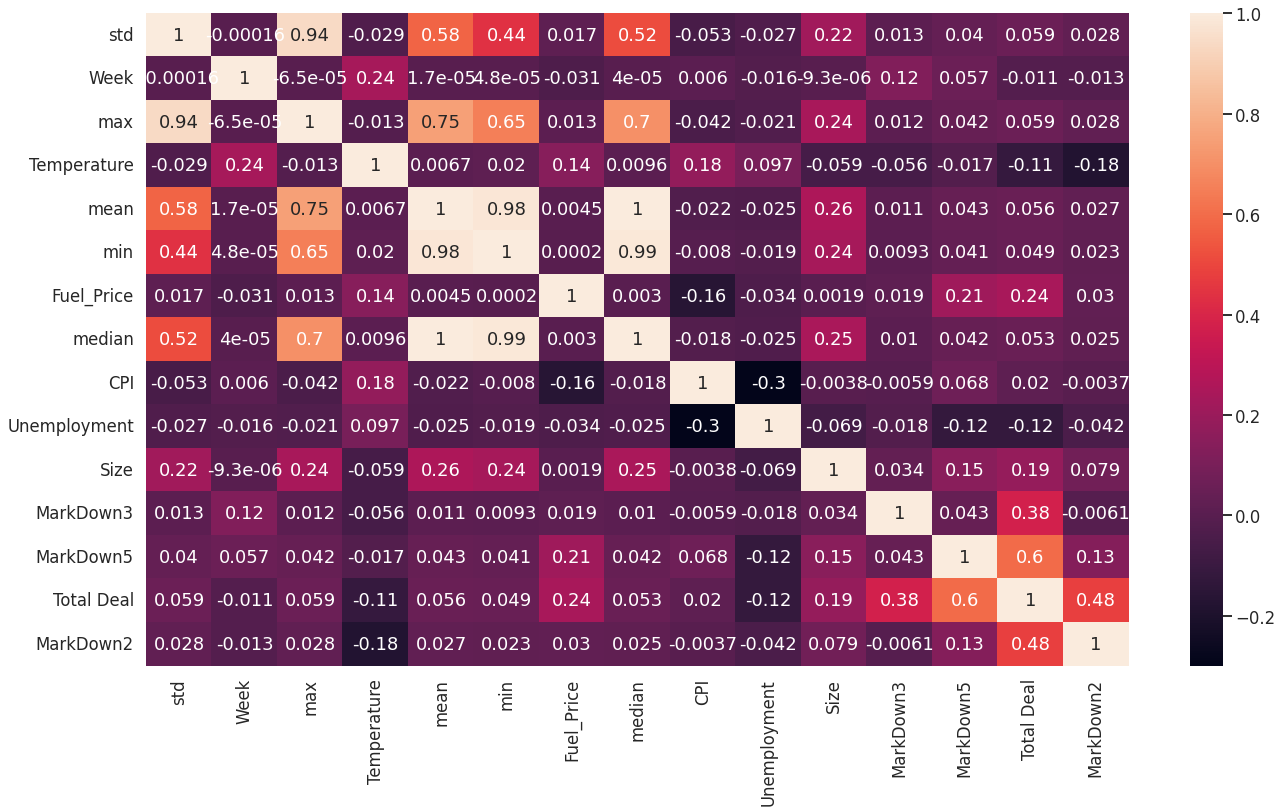

In [217]:
fig, xl = plt.subplots(figsize=(22, 12))
sns.heatmap(A.corr(),annot=True)
plt.show()

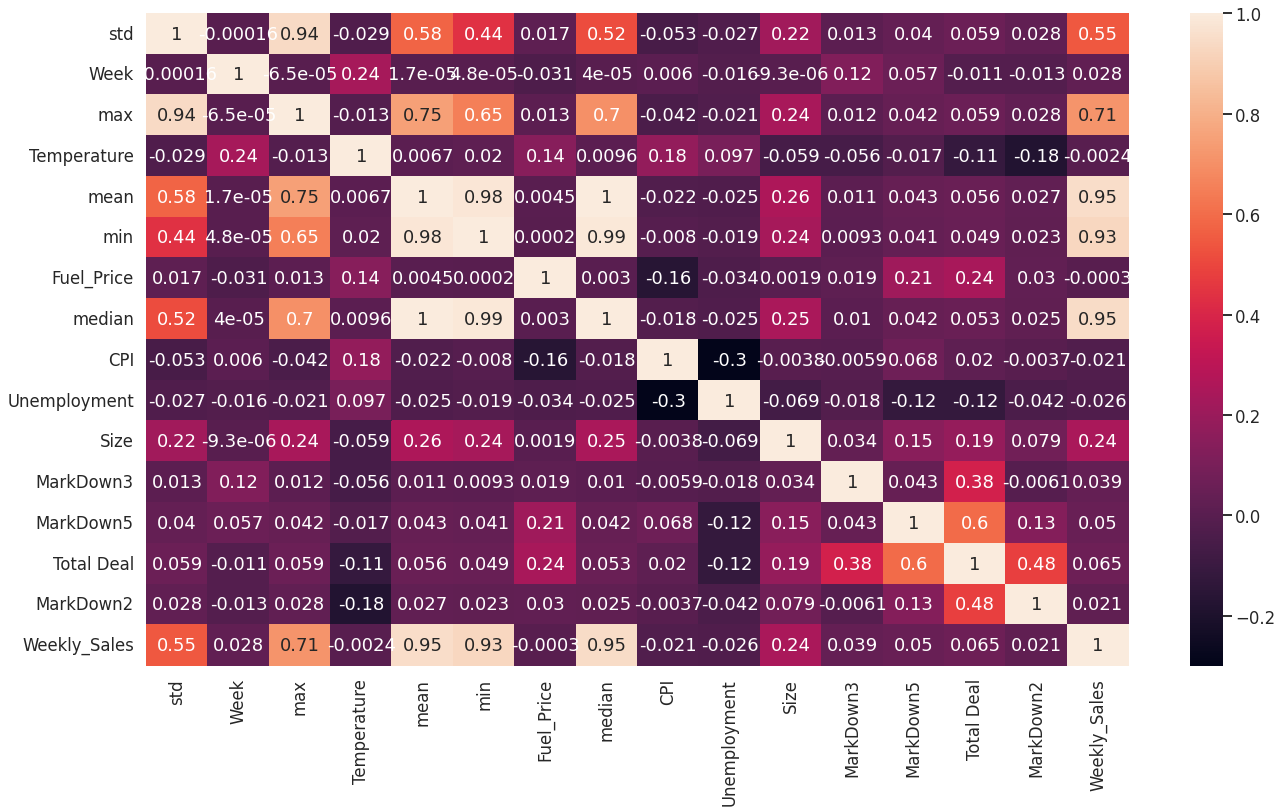

In [218]:
fig, xl = plt.subplots(figsize=(22, 12))
sns.heatmap(dfm.corr(),annot=True)
plt.show()

In [219]:
#dropping the markdowns CPI and unemployment due to low corelation with weekly sales
A=dfm.drop(['CPI','Unemployment','MarkDown2','MarkDown5'],axis=1)
B=dfm.Weekly_Sales

In [220]:
A_test=dfm.drop(['CPI','Unemployment','MarkDown2','MarkDown5'],axis=1)
B_test=dfm.Weekly_Sales

Let's check for 10 components, how much data can we keep when doing the PCA , so that we can keep as much information as possible

In [221]:

pca = PCA(n_components=10)
pca.fit(A_test)
pca_features = pca.transform(A_test)

columns = ['pca_%i' % i for i in range(10)]
A_test= pd.DataFrame(pca_features, columns=columns, index=A_test.index)

In [222]:
var= pca.explained_variance_ratio_
cumvariances=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=3)*100)
print(cumvariances)

[ 56.6  89.7  96.5  99.1  99.6  99.9 100.  100.  100.  100. ]


([<matplotlib.axis.XTick at 0x7f3c57db05d0>,
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, '10')])

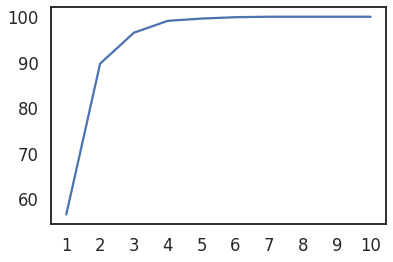

In [223]:
plt.plot(cumvariances)
plt.xticks(np.arange(len(cumvariances)), np.arange(1, len(cumvariances)+1))

As for 5 components it is retrieving most information let's take PCA as 5 and apply them to the models

In [224]:
pca = PCA(n_components=5)
pca.fit(A)
pca_features = pca.transform(A)

columns = ['pca_%i' % i for i in range(5)]
A= pd.DataFrame(pca_features, columns=columns, index=A.index)

In [225]:
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=35)

In [226]:
extratreeregressor_pca = ExtraTreesRegressor(n_estimators=50, max_features='auto', random_state=35)
X_train, X_test, y_train, y_test = train_test_split(A, B, test_size=0.2, random_state=35)
extratreeregressor_pca.fit(X_train, y_train)
y_pred = extratreeregressor_pca.predict(X_test)
mean_absolute_error(y_pred, y_test)

104.44620096030965

In [227]:
print(y_test)

Date
2012-02-10      729.92
2010-09-17     7008.59
2011-08-26     2221.95
2012-06-22    33559.94
2010-10-15    94529.46
                ...   
2010-04-23    59261.02
2010-02-19     5422.56
2010-06-18     4580.82
2011-06-17      220.57
2010-07-30     6022.62
Name: Weekly_Sales, Length: 83723, dtype: float64


In [228]:
print(y_pred)

[ 958.8274 6986.0232 2223.5174 ... 4574.335   221.104  5977.674 ]


In [229]:
print("MAE" , mean_absolute_error(y_test, y_pred))
print("MSE" , mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2" , explained_variance_score(y_test, y_pred))

MAE 104.44620096030965
MSE 235757.93073655208
RMSE 485.5491022919846
R2 0.9995420739913006


In [230]:
etr_mae_pca=mean_absolute_error(y_test, y_pred)
etr_mse_pca=mean_squared_error(y_test, y_pred)
etr_rmse_pca=np.sqrt(mean_squared_error(y_test, y_pred))
etr_r2_pca=explained_variance_score(y_test, y_pred)
print("extra",etr_mae_pca)

extra 104.44620096030965


In [231]:
etr_pred_pca=y_pred

From the above we can see that there is a drastic improvement once PCA has been applied changing the RMSE value from 4082 to 485

In [232]:
#!pip install wandb

# LGBM after PCA

In [233]:
eval_result={}

In [234]:
lgbmmodel = lgb.LGBMRegressor(n_estimators=2000,
        learning_rate=0.4,
        subsample=0.8,
        colsample_bytree=0.8,
        max_depth=10,
        num_leaves=50,
        min_child_weight=300,
        
        )




In [235]:
lgbmhistory=lgbmmodel.fit(X_train, y_train, eval_set=[(X_train,y_train),(X_test,y_test)],
             eval_metric='rmse', verbose=40, early_stopping_rounds=200)

Training until validation scores don't improve for 200 rounds.
[40]	training's l2: 5.27671e+06	training's rmse: 2297.11	valid_1's l2: 3.78058e+06	valid_1's rmse: 1944.37
[80]	training's l2: 3.89909e+06	training's rmse: 1974.61	valid_1's l2: 2.95409e+06	valid_1's rmse: 1718.75
[120]	training's l2: 3.34897e+06	training's rmse: 1830.02	valid_1's l2: 2.71039e+06	valid_1's rmse: 1646.33
[160]	training's l2: 3.05169e+06	training's rmse: 1746.91	valid_1's l2: 2.53196e+06	valid_1's rmse: 1591.21
[200]	training's l2: 2.85025e+06	training's rmse: 1688.27	valid_1's l2: 2.43212e+06	valid_1's rmse: 1559.53
[240]	training's l2: 2.69441e+06	training's rmse: 1641.47	valid_1's l2: 2.36597e+06	valid_1's rmse: 1538.17
[280]	training's l2: 2.55129e+06	training's rmse: 1597.28	valid_1's l2: 2.30533e+06	valid_1's rmse: 1518.33
[320]	training's l2: 2.44022e+06	training's rmse: 1562.12	valid_1's l2: 2.25044e+06	valid_1's rmse: 1500.15
[360]	training's l2: 2.34921e+06	training's rmse: 1532.71	valid_1's l2: 2.2

In [236]:
y_pred=lgbmmodel.predict(X_test)

In [237]:
print("MAE" , mean_absolute_error(y_test, y_pred))
print("MSE" , mean_squared_error(y_test, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2" , explained_variance_score(y_test, y_pred))

MAE 367.8987226684841
MSE 1963233.122078126
RMSE 1401.1542106699483
R2 0.9961840680152328


In [238]:
lgbm_pred_pca=y_pred
lgbm_mae_pca=mean_absolute_error(y_test, y_pred)
lgbm_mse_pca=mean_squared_error(y_test, y_pred)
lgbm_rmse_pca=np.sqrt(mean_squared_error(y_test, y_pred))
lgbm_r2_pca=explained_variance_score(y_test, y_pred)
print("extra",lgbm_mae_pca)

extra 367.8987226684841


# Random Forest with PCA

In [239]:
import math
rf = RandomForestRegressor(n_estimators=50, max_depth=25)
rf.fit(X_train,y_train)
predict=rf.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, predict)))

672.2889378264664


In [240]:
rf_pred_pca=predict

In [241]:
print("MAE" , mean_absolute_error(y_test, predict))
print("MSE" , mean_squared_error(y_test, predict))
print("RMSE" , np.sqrt(mean_squared_error(y_test, predict)))
print("R2" , explained_variance_score(y_test, predict))
print("Score",rf.score(X_train,y_train))

MAE 170.09426912569552
MSE 451972.4159238383
RMSE 672.2889378264664
R2 0.9991218129805524
Score 0.9997849940850813


In [242]:
rf_mae_pca=mean_absolute_error(y_test, predict)
rf_mse_pca=mean_squared_error(y_test, predict)
rf_rmse_pca=np.sqrt(mean_squared_error(y_test, predict))
rf_r2_pca=explained_variance_score(y_test, predict)
print("extra",rf_mae_pca)

extra 170.09426912569552


# Decision Tree Regressor with PCA

In [243]:
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train,y_train)
predictions = dt.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, predictions)))

992.2735732635402


In [244]:
print("MAE" , mean_absolute_error(y_test, predictions))
print("MSE" , mean_squared_error(y_test, predictions))
print("RMSE" , np.sqrt(mean_squared_error(y_test, predictions)))
print("R2" , explained_variance_score(y_test, predictions))
print("Score",rf.score(X_train,y_train))

MAE 266.74953513371474
MSE 984606.8441971944
RMSE 992.2735732635402
R2 0.9980862637179017
Score 0.9997849940850813


In [245]:
dt_pred_pca=predictions

In [246]:
dt_mae_pca=mean_absolute_error(y_test, predictions)
dt_mse_pca=mean_squared_error(y_test, predictions)
dt_rmse_pca=np.sqrt(mean_squared_error(y_test, predictions))
dt_r2_pca=explained_variance_score(y_test, predictions)
print("extra",dt_mae_pca)

extra 266.74953513371474


# XGBoost Regressor with PCA

In [247]:
from xgboost import XGBRegressor
xgmodel = XGBRegressor(random_state=48, n_jobs=-1, n_estimators=20, max_depth=12)
xgmodel.fit(X_train,y_train)
predictions=xgmodel.predict(X_test)
print(math.sqrt(mean_squared_error(y_test, predictions)))

[02:31:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
3666.3173501508136


In [248]:
print("MAE" , mean_absolute_error(y_test, predictions))
print("MSE" , mean_squared_error(y_test, predictions))
print("RMSE" , np.sqrt(mean_squared_error(y_test, predictions)))
print("R2" , explained_variance_score(y_test, predictions))
print("Score",rf.score(X_train,y_train))

MAE 2120.348912395405
MSE 13441882.912016883
RMSE 3666.3173501508136
R2 0.9814723070079492
Score 0.9997849940850813


In [249]:
xgb_mae_pca=mean_absolute_error(y_test, predictions)
xgb_mse_pca=mean_squared_error(y_test, predictions)
xgb_rmse_pca=np.sqrt(mean_squared_error(y_test, predictions))
xgb_r2_pca=explained_variance_score(y_test, predictions)
print("extra",xgb_mae_pca)

extra 2120.348912395405


In [250]:
xgb_pred_pca=predictions

In [251]:
X=dfm.drop(['Weekly_Sales'],axis=1)
Y=dfm.Weekly_Sales
X_train,X_test,y_train,y_test = train_test_split(X,Y,test_size=0.20, random_state=35)

Comparision Charts

In [252]:
actual_test=pd.DataFrame(y_test)
actual_test.reset_index(drop=True,inplace=True)

In [253]:
#Creating multiple dataframes for charts
df_xgb=pd.DataFrame(xgb_pred_pca)
df_et=pd.DataFrame(etr_pred_pca)
df_lgbm=pd.DataFrame(lgbm_pred_pca)
df_dt=pd.DataFrame(dt_pred_pca)
df_rf=pd.DataFrame(rf_pred_pca)
df_tests=actual_test.copy()
df_tests['xgb']=df_xgb
df_tests['et']=df_et
df_tests['lgbm']=df_lgbm
df_tests['dt']=df_dt
df_tests['rf']=df_rf
df_tests['index']=df_tests.index

In [254]:
df_tests

,Weekly_Sales,xgb,et,lgbm,dt,rf,index
0,729.92,1179.075684,958.8274,728.206364,888.54,763.135281,0
1,7008.59,5331.438965,6986.0232,6682.323649,6791.32,6608.728667,1
2,2221.95,1922.642700,2223.5174,2356.735878,2219.63,2235.105012,2
3,33559.94,29707.974609,33517.3528,33795.848649,34209.28,33483.699959,3
4,94529.46,83525.078125,94598.6626,94984.692995,94608.46,94638.870800,4
...,...,...,...,...,...,...,...
83718,59261.02,52167.156250,59232.4310,59105.847442,59157.08,59332.649200,83718
83719,5422.56,5399.290527,5361.6838,5257.675164,5386.00,5525.707368,83719
83720,4580.82,3704.347412,4574.3350,4579.176745,4599.30,4580.987026,83720
83721,220.57,448.497498,221.1040,389.760058,232.44,268.277790,83721


# Normal Plots

xgb

In [255]:
import warnings
warnings.filterwarnings("ignore")

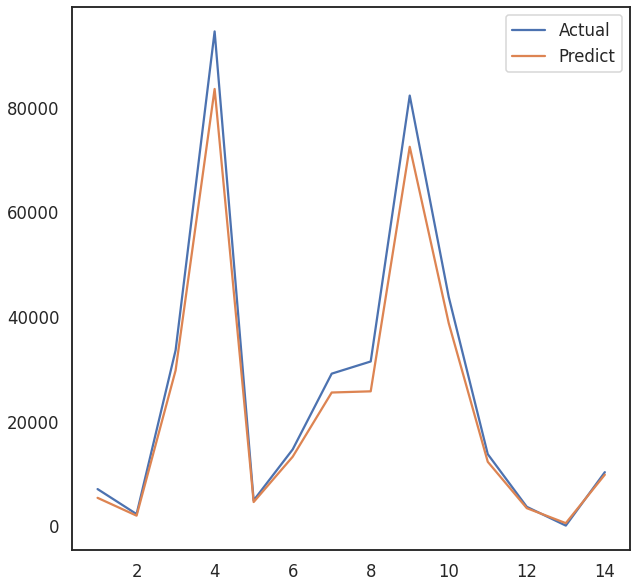

In [256]:
fig, ax = plt.subplots(figsize=(10,10))
labels=['Actual', 'Predict']
colors=['r','g']
ax.plot(actual_test[1:15],label='Actual')
ax.plot(df_xgb[1:15],label='Predict')
ax.legend()
plt.show()

ExtraTreeRegressor


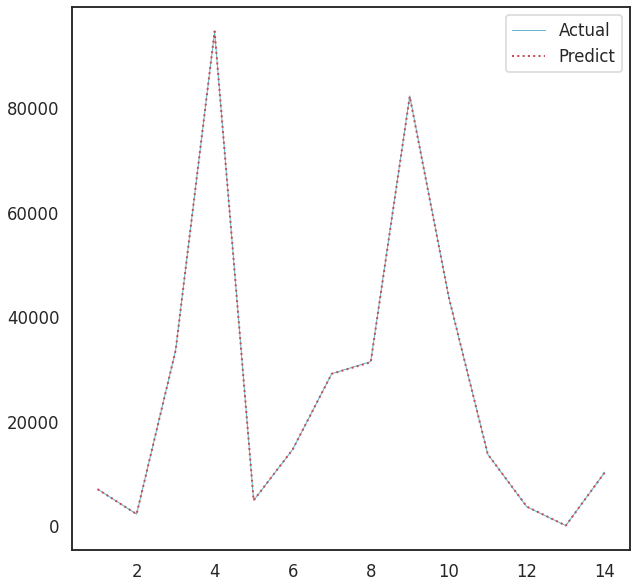

In [257]:
#BEST MODEL
fig, ax = plt.subplots(figsize=(10,10))
labels=['Actual', 'Predict']
colors=['r','g']
ax.plot(actual_test[1:15],'c-',linewidth=1,label='Actual')
ax.plot(df_et[1:15],'r:',linewidth=2,label='Predict')
ax.legend()
plt.show()

LGBM


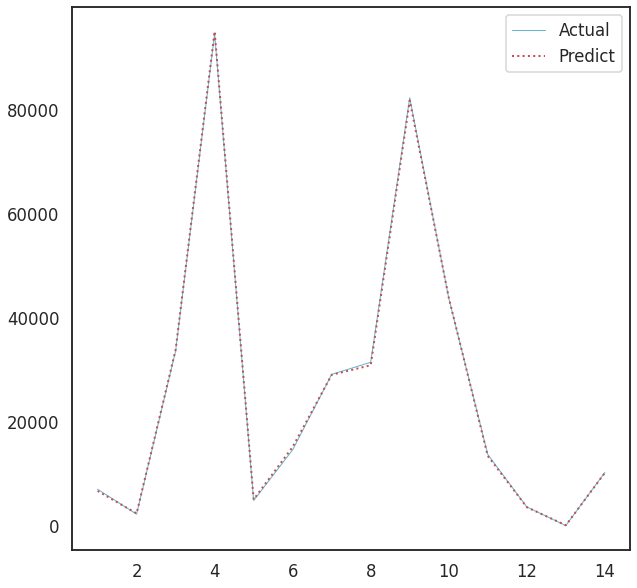

In [258]:
fig, ax = plt.subplots(figsize=(10,10))
labels=['Actual', 'Predict']
colors=['r','g']
ax.plot(actual_test[1:15],'c-',linewidth=1,label='Actual')
ax.plot(df_lgbm[1:15],'r:',linewidth=2,label='Predict')
ax.legend()
plt.show()

Decision Tree

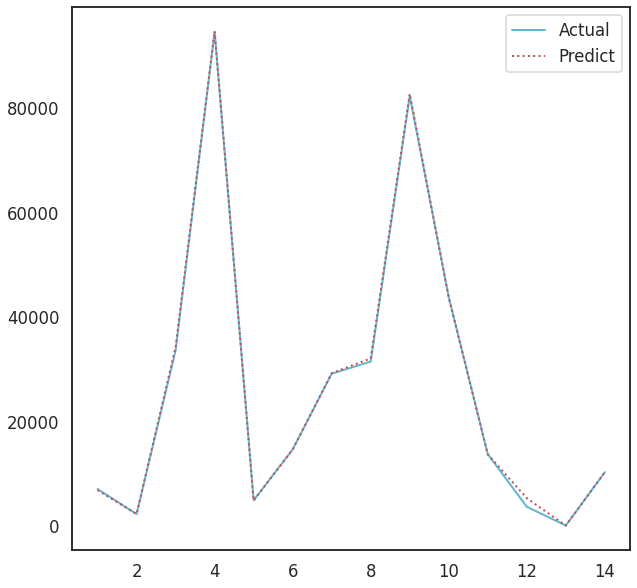

In [259]:
fig, ax = plt.subplots(figsize=(10,10))
labels=['Actual', 'Predict']
colors=['r','g']
ax.plot(actual_test[1:15],'c-',linewidth=2,label='Actual')
ax.plot(df_dt[1:15],'r:',linewidth=2,label='Predict')
ax.legend()
plt.show()

Random Forest

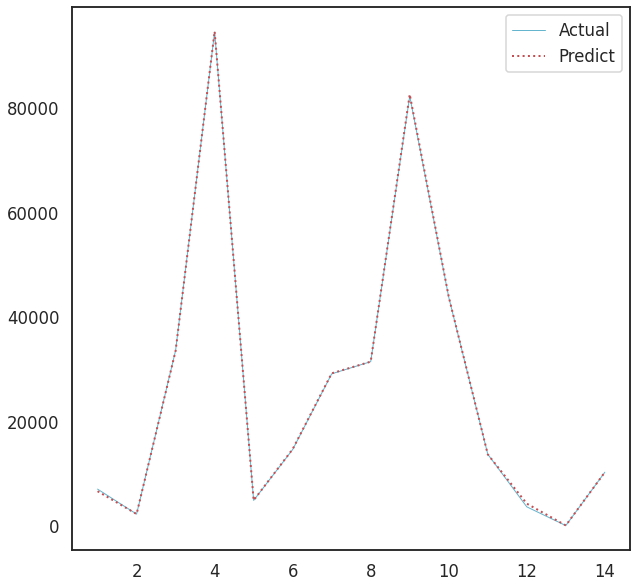

In [260]:
fig, ax = plt.subplots(figsize=(10,10))
labels=['Actual', 'Predict']
colors=['r','g']
ax.plot(actual_test[1:15],'c-',linewidth=1,label='Actual')
ax.plot(df_rf[1:15],'r:',linewidth=2,label='Predict')
ax.legend()
plt.show()

# Plotly


XGB Regressor

In [261]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['xgb'][1:15], name="Predict"),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['Weekly_Sales'][1:15], name="Actual"),
    secondary_y=True,
)

fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

ExtraTree Regressor

In [262]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['et'][1:15], name="Predict"),
    secondary_y=False,
)

# Graph2
fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['Weekly_Sales'][1:15], name="Actual"),
    secondary_y=True,
)

fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

LGBM

In [263]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['lgbm'][1:15], name="Predict"),
    secondary_y=False,
)

# Graph2
fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['Weekly_Sales'][1:15], name="Actual"),
    secondary_y=True,
)

fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

Decision Tree Regressor

In [264]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['dt'][1:15], name="Predict"),
    secondary_y=False,
)

# Graph2
fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['Weekly_Sales'][1:15], name="Actual"),
    secondary_y=True,
)

fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

RandomForest Regressor

In [265]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(specs=[[{"secondary_y": True}]])


fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['rf'][1:15], name="Predict"),
    secondary_y=False,
)

# Graph2
fig.add_trace(
    go.Scatter(x=df_tests['index'][1:15], y=df_tests['Weekly_Sales'][1:15], name="Actual"),
    secondary_y=True,
)

fig.update_yaxes(title_text="<b>primary</b> yaxis title", secondary_y=False)
fig.update_yaxes(title_text="<b>secondary</b> yaxis title", secondary_y=True)

fig.show()

Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

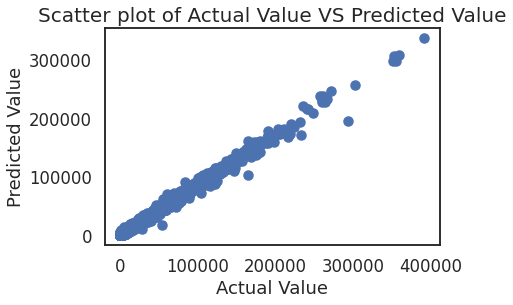

In [276]:
plt.scatter(df_tests['Weekly_Sales'], df_tests['xgb'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)


Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

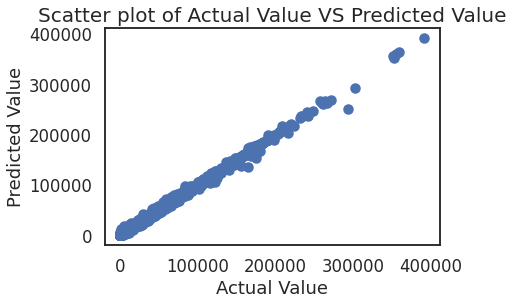

In [277]:
plt.scatter(df_tests['Weekly_Sales'], df_tests['et'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)

Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

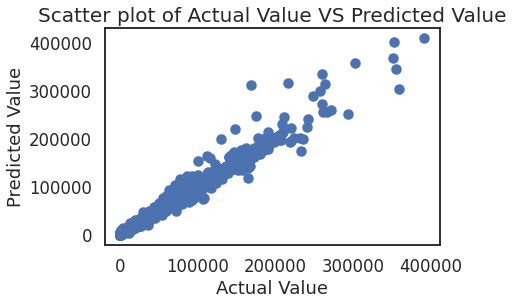

In [279]:
plt.scatter(df_tests['Weekly_Sales'], df_tests['lgbm'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)

Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

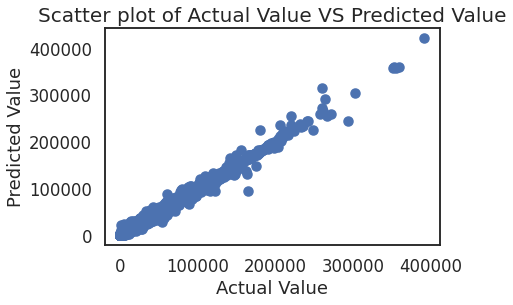

In [280]:
plt.scatter(df_tests['Weekly_Sales'], df_tests['dt'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)

Text(0.5, 1.0, 'Scatter plot of Actual Value VS Predicted Value')

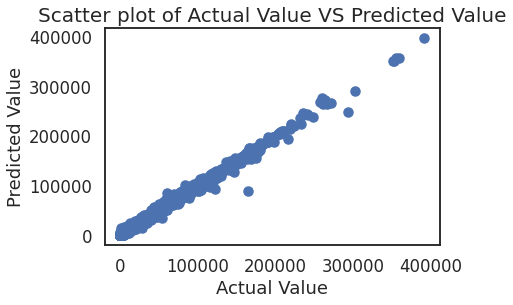

In [281]:
plt.scatter(df_tests['Weekly_Sales'], df_tests['rf'])
plt.xlabel('Actual Value', fontsize = 18)
plt.ylabel('Predicted Value', fontsize = 18)
plt.title("Scatter plot of Actual Value VS Predicted Value", fontsize = 20)

# ARIMA

In [6]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

In [7]:
df=pd.read_csv('clean_data.csv')

In [8]:
df.drop(columns=['Unnamed: 0'],inplace=True)

In [9]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
420208,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
420209,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
420210,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012


In [9]:
df

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,...,Unemployment,Type,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
0,1,1,2010-02-05,24924.50,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
1,1,2,2010-02-05,50605.27,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
2,1,3,2010-02-05,13740.12,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
3,1,4,2010-02-05,39954.04,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
4,1,5,2010-02-05,32229.38,False,42.31,2.572,0.00,0.00,0.0,...,8.106,A,151315,False,False,False,False,5,2,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420207,45,93,2012-10-26,2487.80,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
420208,45,94,2012-10-26,5203.31,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
420209,45,95,2012-10-26,56017.47,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012
420210,45,97,2012-10-26,6817.48,False,58.85,3.882,4018.91,58.08,100.0,...,8.667,B,118221,False,False,False,False,43,10,2012


In [10]:
df["Date"] = pd.to_datetime(df["Date"])

In [11]:
df.set_index('Date', inplace=True)

In [12]:
#from previous observations it could be seen that there is no pattern that could be seen due to repetitive   per time frame 
# first for the weekly data
df_week = df.resample('W').mean()

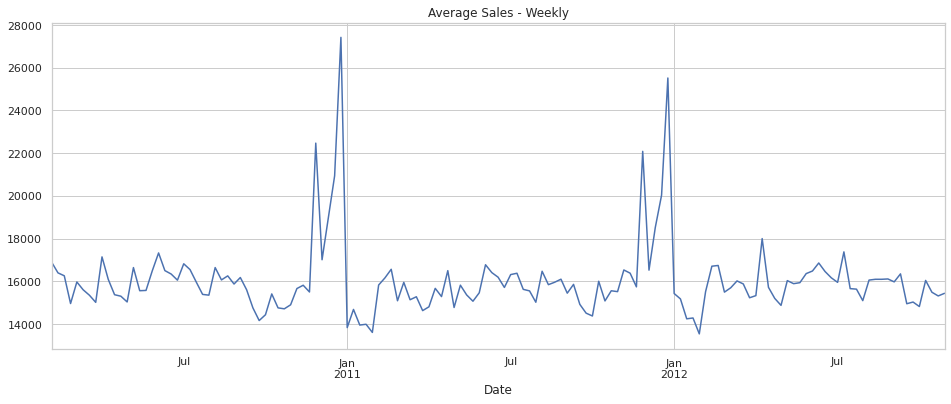

In [13]:
plt.figure(figsize=(16,6))
df_week['Weekly_Sales'].plot()
plt.title('Average Sales - Weekly')
plt.show()

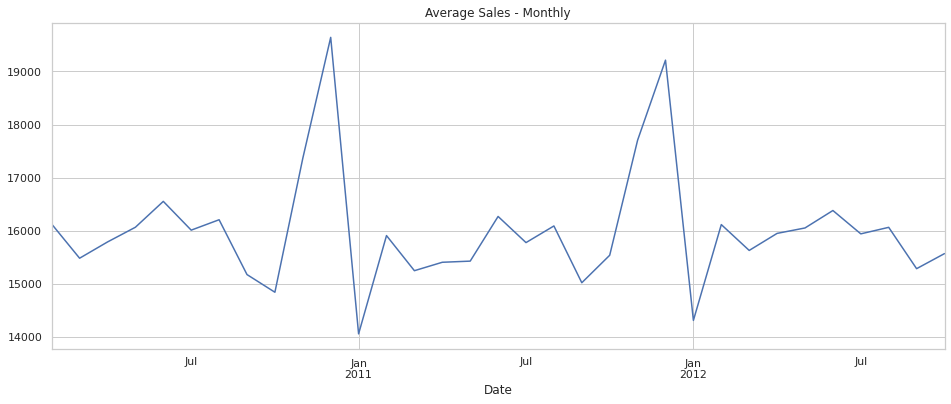

In [14]:
df_month = df.resample('MS').mean() # resampling as monthly
plt.figure(figsize=(16,6))
df_month['Weekly_Sales'].plot()
plt.title('Average Sales - Monthly')
plt.show()

In [15]:
rolling_mean=df_week['Weekly_Sales'].rolling(window=2, center=False).mean()
rolling_std = df_week['Weekly_Sales'].rolling(window=2, center=False).std()

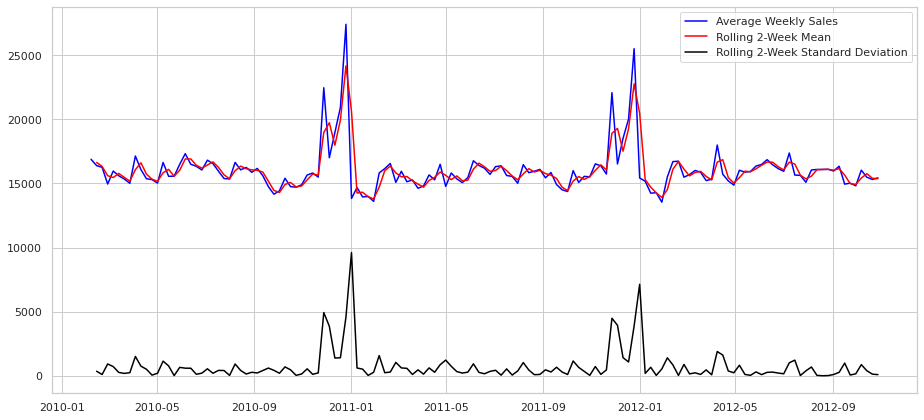

In [16]:
fig, ax = plt.subplots(figsize=(13, 6))
ax.plot(df_week['Weekly_Sales'], color='blue',label='Average Weekly Sales')
ax.plot(rolling_mean, color='red', label='Rolling 2-Week Mean')
ax.plot(rolling_std, color='black', label='Rolling 2-Week Standard Deviation')
ax.legend()
fig.tight_layout()

In [17]:
from statsmodels.tsa.stattools import adfuller

In [18]:
adfuller(df_week['Weekly_Sales'])

(-5.927107223737572,
 2.4290492082042356e-07,
 4,
 138,
 {'1%': -3.47864788917503,
  '10%': -2.578065326612056,
  '5%': -2.882721765644168},
 2261.596421168073)

Since i want continous data and also data has to be forecasted so we use split manually

In [19]:
train_data = df_week[:int(0.7*(len(df_week)))] 
test_data = df_week[int(0.7*(len(df_week))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (100, 21)
Test: (43, 21)


In [20]:
target = "Weekly_Sales"
used_cols = [c for c in df_week.columns.to_list() if c not in [target]]



X_train = train_data[used_cols]
X_test = test_data[used_cols]
y_train = train_data[target]
y_test = test_data[target]

In [21]:
X_train

,Store,Dept,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Size,Super_Bowl,Labor_Day,Thanksgiving,Christmas,week,month,year
Date,,,,,,,,,,,,,,,,,,,,
2010-02-07,22.040394,44.161236,0.0,33.282800,2.717968,0.000000,0.000000,0.000000,0.000000,0.000000,167.328549,8.578592,137381.684997,0.0,0.0,0.0,0.0,5.0,2.0,2010.0
2010-02-14,22.006443,44.331638,1.0,33.370444,2.695955,0.000000,0.000000,0.000000,0.000000,0.000000,167.401961,8.567855,137675.080027,1.0,0.0,0.0,0.0,6.0,2.0,2010.0
2010-02-21,22.044444,44.287542,0.0,37.032596,2.673506,0.000000,0.000000,0.000000,0.000000,0.000000,167.386208,8.574593,137277.810101,0.0,0.0,0.0,0.0,7.0,2.0,2010.0
2010-02-28,22.021088,44.058844,0.0,38.624806,2.685486,0.000000,0.000000,0.000000,0.000000,0.000000,167.708233,8.562094,137365.977551,0.0,0.0,0.0,0.0,8.0,2.0,2010.0
2010-03-07,22.056199,44.019755,0.0,42.367490,2.731923,0.000000,0.000000,0.000000,0.000000,0.000000,167.680036,8.573890,137556.273161,0.0,0.0,0.0,0.0,9.0,3.0,2010.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011-12-04,22.176589,44.468562,0.0,45.620211,3.396139,4564.297375,77.139555,3591.739953,2709.845217,18692.618358,173.008818,7.773589,136320.525753,0.0,0.0,0.0,0.0,48.0,12.0,2011.0
2011-12-11,22.198600,44.693769,0.0,37.948737,3.363338,4655.367614,26.454692,338.066271,2326.262333,9723.775528,173.245926,7.769220,136189.639787,0.0,0.0,0.0,0.0,49.0,12.0,2011.0
2011-12-18,22.169667,44.696333,0.0,40.618243,3.335765,3192.691327,62.372197,726.737090,549.652043,4054.178953,173.529024,7.763204,136188.219667,0.0,0.0,0.0,0.0,50.0,12.0,2011.0


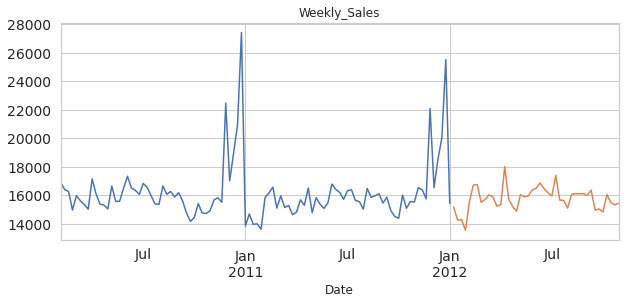

In [22]:
#split data visualisation
train_data['Weekly_Sales'].plot(figsize=(10,4), title= 'Weekly_Sales', fontsize=14)
test_data['Weekly_Sales'].plot(figsize=(10,4), title= 'Weekly_Sales', fontsize=14)
plt.show()

In [23]:
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima import auto_arima

In [24]:
decomposed = decompose(df_week['Weekly_Sales'].values, 'additive', m=20)

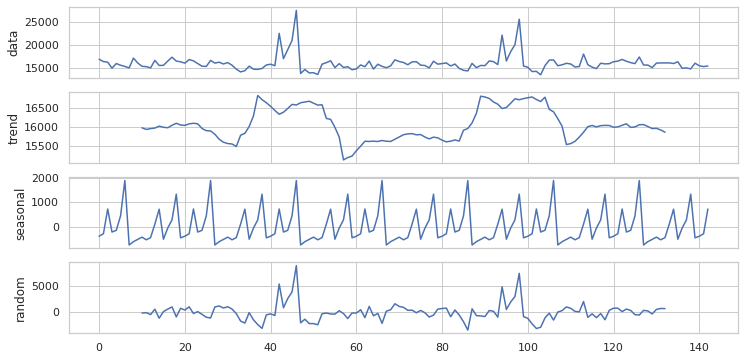

In [25]:
decomposed_plot(decomposed, figure_kwargs={'figsize': (12, 6)})
plt.show()

In [27]:
df_weekly_dif = df_week['Weekly_Sales'].diff().dropna()

In [29]:
weeklydif_roll_mean = df_weekly_dif.rolling(window=2, center=False).mean()
weeklydif_roll_std = df_weekly_dif.rolling(window=2, center=False).std()

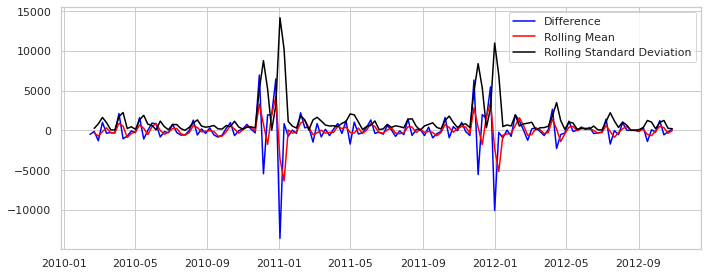

In [34]:
fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(df_weekly_dif, color='blue',label='Difference')
ax.plot(weeklydif_roll_mean, color='red', label='Rolling Mean')
ax.plot(weeklydif_roll_std, color='black', label='Rolling Standard Deviation')
ax.legend()
fig.tight_layout()

In [57]:
train_data = df_weekly_dif [:int(0.7*(len(df_weekly_dif )))]
test_data = df_weekly_dif [int(0.7*(len(df_weekly_dif ))):]

In [58]:
arimamodel = auto_arima(train_data, trace=True,start_p=0, start_q=0, start_P=0, start_Q=0,
                  max_p=20, max_q=20, max_P=20, max_Q=20, seasonal=True,maxiter=200,
                  information_criterion='aic',stepwise=False, suppress_warnings=True, D=1, max_D=10,
                  error_action='ignore',approximation = False)
arimamodel.fit(train_data)

 ARIMA(0,0,0)(0,0,0)[1] intercept   : AIC=1826.858, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[1] intercept   : AIC=1793.619, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[1] intercept   : AIC=1795.532, Time=0.29 sec
 ARIMA(0,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=0.33 sec
 ARIMA(0,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,5)(0,0,0)[1] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(1,0,0)(0,0,0)[1] intercept   : AIC=1804.051, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(1,0,2)(0,0,0)[1] intercept   : AIC=1794.966, Time=0.44 sec
 ARIMA(1,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(1,0,4)(0,0,0)[1] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(2,0,0)(0,0,0)[1] intercept   : AIC=1801.215, Time=0.06 sec
 ARIMA(2,0,1)(0,0,0)[1] intercept   : AIC=inf, Time=0.86 sec
 ARIMA(2,0,2)(0,0,0)[1] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(2,0,3)(0,0,0)[1] intercept   : AIC=inf, Time=1.00 sec
 ARIMA(3,0,0)(0,0,0)[1] intercept   : AIC=1791.045, Tim

ARIMA(maxiter=200, order=(3, 0, 2), scoring_args={},
      seasonal_order=(0, 0, 0, 1), suppress_warnings=True)

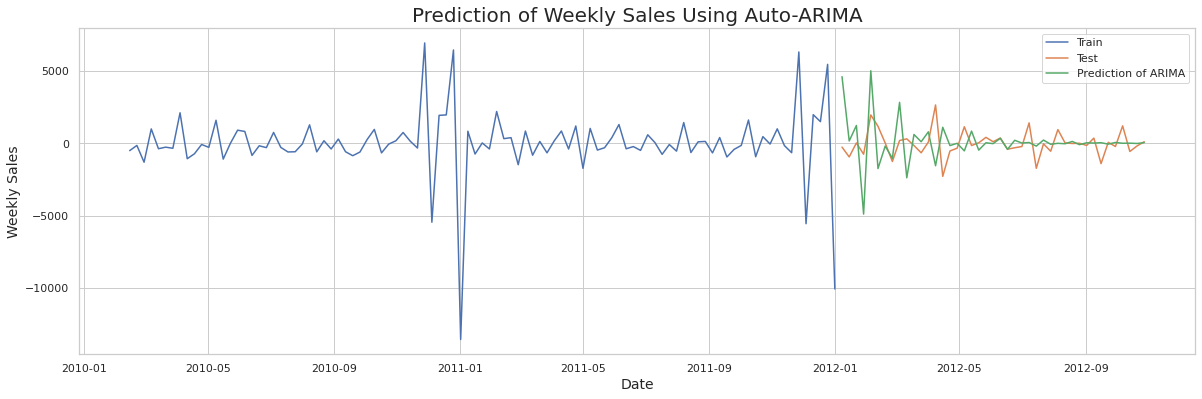

In [59]:
y_pred = arimamodel.predict(n_periods=len(test_data))
y_pred = pd.DataFrame(y_pred,index = test_data.index,columns=['Prediction'])
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales Using Auto-ARIMA', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_pred, label='Prediction of ARIMA')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [60]:
print("MAE" , mean_absolute_error(test_data, y_pred))
print("MSE" , mean_squared_error(test_data, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(test_data, y_pred)))


MAE 1103.6812164794576
MSE 2827182.175524166
RMSE 1681.4226641520465


In [50]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: the 'damped'' keyword is deprecated, use 'damped_trend' instead
  
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning,


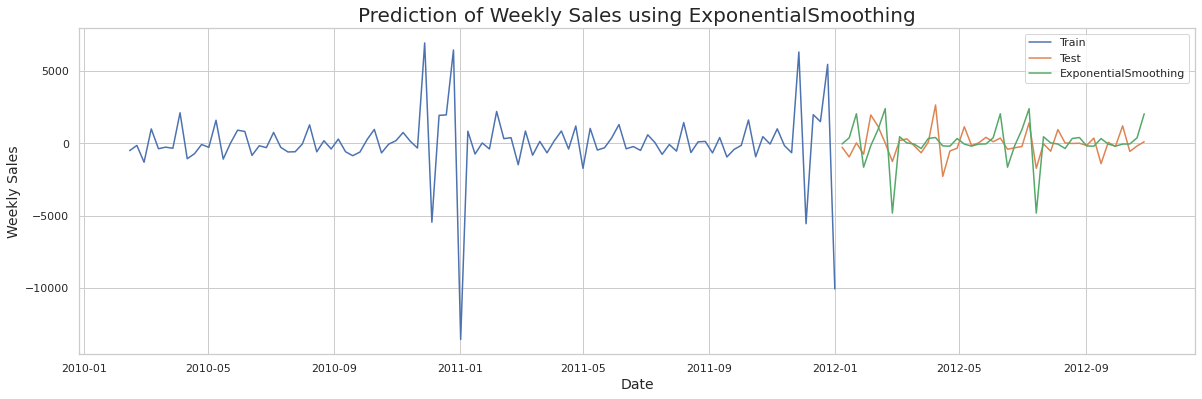

In [61]:
model_exponential = ExponentialSmoothing(train_data, seasonal_periods=20, seasonal='additive',
                                           trend='additive',damped=True).fit() 
y_pred = model_exponential.forecast(len(test_data))

#Visualize train, test and predicted data.
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using ExponentialSmoothing', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(y_pred, label='ExponentialSmoothing')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [62]:
print("MAE" , mean_absolute_error(test_data, y_pred))
print("MSE" , mean_squared_error(test_data, y_pred))
print("RMSE" , np.sqrt(mean_squared_error(test_data, y_pred)))


MAE 923.119482259168
MSE 1616960.316254969
RMSE 1271.597544923302
